# Descriptivos y cruce de base scrapping con ranking

La base inicial con ranking consta de 1400 registros aprox con jugadores duplicados o triplicados variando la posicion, obteniendo un total 870 jugadores unicos.

En un inicio se agrupara por jugador y se generaran variables dummies de POSICIÓN, NACIONALIDAD, EQUIPO_ANTERIOR y se dejan las variables numericas de minutos por posicion, totales, ranking, edad.

In [972]:
# lectura de archivo y filtros o trasnformaciones
import numpy as np
import pandas as pd

# limpieza de nombres
import re
import unidecode

# calculo de edad
import datetime

# visualizacion de datos
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,8)


In [973]:
df_15 = pd.read_excel('ránking jugadores Liga Argentina Temporadas 16-17; 17-18 .xlsx', sheet_name='temp_16_17')
# df_17 = pd.read_excel('ránking jugadores Liga Argentina Temporadas 16-17; 17-18 .xlsx', sheet_name='temp_17_18')

In [974]:
df_15.head()

,Jugador,Posición,Fecha de Nacimiento,Nacionalidad,Minutos Jugados Temporada 15-16,Suma Ponderada Agregada Temporada 15-16,Suma Ponderada Agregada restringida Temporada 15-16
0,"Acosta, Lautaro",Volante por izquierda,1988-03-14,Argentina,1842,3.784080,3.78408
1,"Aguirre, Jonas",Volante por izquierda,1992-03-05,Argentina,1295,4.726390,4.72639
2,"Alanis, Gabriel",Volante por izquierda,1994-03-16,Argentina,118,3.117585,0.00000
3,"Alaniz, Diego",Volante por izquierda,1993-02-19,Uruguaya,299,2.853512,0.00000
4,"Andrada, Omar Brian",Volante por izquierda,1997-06-22,Argentina,6,6.450000,0.00000


# Procesamiento de datos

In [975]:
# 1487 jugadores en la temporada 16-17 #contiene duplicados
df_15.shape

(1487, 7)

In [976]:
# cambio de nombres a las columnas...
df_15.columns = ['jugador', 'posicion', 'fecha_nacimiento', 'nacionalidad',
       'minutos_jugados','ranking','ranking_restringido']
df_15.columns

Index(['jugador', 'posicion', 'fecha_nacimiento', 'nacionalidad',
       'minutos_jugados', 'ranking', 'ranking_restringido'],
      dtype='object')

In [977]:
df_15.head()

,jugador,posicion,fecha_nacimiento,nacionalidad,minutos_jugados,ranking,ranking_restringido
0,"Acosta, Lautaro",Volante por izquierda,1988-03-14,Argentina,1842,3.784080,3.78408
1,"Aguirre, Jonas",Volante por izquierda,1992-03-05,Argentina,1295,4.726390,4.72639
2,"Alanis, Gabriel",Volante por izquierda,1994-03-16,Argentina,118,3.117585,0.00000
3,"Alaniz, Diego",Volante por izquierda,1993-02-19,Uruguaya,299,2.853512,0.00000
4,"Andrada, Omar Brian",Volante por izquierda,1997-06-22,Argentina,6,6.450000,0.00000


In [978]:
#numero de jugadores unicos
len(df_15.groupby(['jugador','fecha_nacimiento','nacionalidad']).posicion.unique().index)

875

In [979]:
#agrupado por nombre, fch_nacimiento, nacionalidad para obtener la nacionalidad
df_15.groupby(['jugador','fecha_nacimiento','nacionalidad']).posicion.unique()[:5]

jugador            fecha_nacimiento  nacionalidad
Abelairas, Matias  1985-06-18        Argentina         [Volante Mixto , Volante ofensivo]
Abila, Ramon       1989-10-14        Argentina       [Delantero, Delantero con Movilidad]
Acevedo, Lucas     1991-11-08        Argentina                          [Defensa central]
Acevedo, Nelson    1988-07-11        Argentina        [Volante defensivo, Volante Mixto ]
Acevedo, Walter    1986-02-16        Argentina        [Volante defensivo, Volante Mixto ]
Name: posicion, dtype: object

In [980]:
# numero de posiciones por jugador
np.unique([len(i) for i in df_15.groupby(['jugador','fecha_nacimiento','nacionalidad']).posicion.unique().values])

array([1, 2, 3])

In [981]:
# Lista de posiciones
posicion_1 = [df_15.groupby(['jugador','fecha_nacimiento','nacionalidad']).posicion.unique().str[0].values]
posicion_2 = [df_15.groupby(['jugador','fecha_nacimiento','nacionalidad']).posicion.unique().str[1].values]
posicion_3 = [df_15.groupby(['jugador','fecha_nacimiento','nacionalidad']).posicion.unique().str[2].values]

In [982]:
# Check que el numero de posiciones corresponda al numero de jugadores unicos
len(posicion_1[0])

875

### Existen duplicados

In [983]:
# Quito duplicados y me quedo con el primero... en total se vuelan 10 registro
print("numero inicial de datos:", df_15.shape[0])
df_15.drop_duplicates(subset=['jugador','fecha_nacimiento','nacionalidad','posicion'],inplace=True)
print("numero final de datos:", df_15.shape[0])

numero inicial de datos: 1487
numero final de datos: 1479


## RANK de posicion para extraer sus valores.

In [984]:
#obtengo un rango de posicion para indicarle el valor de la posicion
rank_posicion = df_15.groupby(['jugador','fecha_nacimiento','nacionalidad']).minutos_jugados.rank(method='first').values

# para generar valores de posicion se genera un rank
df_15['rank_posicion'] = rank_posicion

# Minutos jugados
min_jugados_pos1 = np.where(df_15.rank_posicion == 1, df_15.minutos_jugados, np.nan)
min_jugados_pos2 = np.where(df_15.rank_posicion == 2, df_15.minutos_jugados, np.nan)
min_jugados_pos3 = np.where(df_15.rank_posicion == 3, df_15.minutos_jugados, np.nan)

# ranking por posicion
ranking_pos1 = np.where(df_15.rank_posicion == 1, df_15.ranking, np.nan)
ranking_pos2 = np.where(df_15.rank_posicion == 2, df_15.ranking, np.nan)
ranking_pos3 = np.where(df_15.rank_posicion == 3, df_15.ranking, np.nan)

# ranking_restringido por posicion
ranking_restringido_pos1 = np.where(df_15.rank_posicion == 1, df_15.ranking_restringido, np.nan)
ranking_restringido_pos2 = np.where(df_15.rank_posicion == 2, df_15.ranking_restringido, np.nan)
ranking_restringido_pos3 = np.where(df_15.rank_posicion == 3, df_15.ranking_restringido, np.nan)

## Se generan las columnas
df_15['minutos_jugados_pos1'] = min_jugados_pos1
df_15['minutos_jugados_pos2'] = min_jugados_pos2
df_15['minutos_jugados_pos3'] = min_jugados_pos3

df_15['ranking_pos1'] = ranking_pos1
df_15['ranking_pos2'] = ranking_pos2
df_15['ranking_pos3'] = ranking_pos3

df_15['ranking_restringido_pos1'] = ranking_restringido_pos1
df_15['ranking_restringido_pos2'] = ranking_restringido_pos2
df_15['ranking_restringido_pos3'] = ranking_restringido_pos3

In [985]:
# Se agrupa por jugador los valores numericos.
agrupado_df_min_rank = df_15.groupby(['jugador','fecha_nacimiento','nacionalidad']).mean()[[
       'minutos_jugados_pos1', 'minutos_jugados_pos2', 'minutos_jugados_pos3',
       'ranking_pos1', 'ranking_pos2', 'ranking_pos3',
       'ranking_restringido_pos1', 'ranking_restringido_pos2',
       'ranking_restringido_pos3']]

# se generan las columnas de posicion
agrupado_df_min_rank['posicion_1'] = posicion_1[0]
agrupado_df_min_rank['posicion_2'] = posicion_2[0]
agrupado_df_min_rank['posicion_3'] = posicion_3[0]

# dataframe casi listo
df_pre_final = agrupado_df_min_rank.reset_index()

In [986]:
df_pre_final.head(3)

,jugador,fecha_nacimiento,nacionalidad,minutos_jugados_pos1,minutos_jugados_pos2,minutos_jugados_pos3,ranking_pos1,ranking_pos2,ranking_pos3,ranking_restringido_pos1,ranking_restringido_pos2,ranking_restringido_pos3,posicion_1,posicion_2,posicion_3
0,"Abelairas, Matias",1985-06-18,Argentina,128.0,128.0,NaN,9.485156,6.644531,NaN,0.00000,0.000000,NaN,Volante Mixto,Volante ofensivo,NaN
1,"Abila, Ramon",1989-10-14,Argentina,2094.0,2094.0,NaN,2.281160,1.449713,NaN,2.28116,1.449713,NaN,Delantero,Delantero con Movilidad,NaN
2,"Acevedo, Lucas",1991-11-08,Argentina,379.0,NaN,NaN,7.387124,NaN,NaN,0.00000,NaN,NaN,Defensa central,NaN,NaN


## Preprocesamiento de Nombres
Se procesan los nombres del archivo de jugadores ranking para el cruce con la tabla de precio

In [987]:
#se quitan acentos
df_pre_final['jugador'] = [unidecode.unidecode(nombre) for nombre in df_pre_final.jugador]

In [988]:
df_pre_final.jugador.unique()[:5]

array(['Abelairas, Matias', 'Abila, Ramon', 'Acevedo, Lucas',
       'Acevedo, Nelson', 'Acevedo, Walter'], dtype=object)

In [989]:
df_pre_final.jugador.unique()[400:405]

array(['Gonzalez, Leandro', 'Gonzalez, Luis Oscar',
       'Gonzalez, Maximiliano David', 'Gonzalez, Nicolas',
       'Gonzalez, Sergio'], dtype=object)

Como observamos se divide en Apellido, Nombre.... En algunos casos existen dos nombres

In [990]:
df_pre_final.jugador.unique()[700:705]

array(['Romero Gamarra, Alejandro', 'Romero, Braian Ezequiel',
       'Romero, Dardo Guido', 'Romero, Lucas', 'Romero, Oscar'],
      dtype=object)

En otros casos tienen 2 apellidos.

__Se ha visto que tienen hasta 3 nombres o 3 apellidos.__

In [991]:
# Se extrae el primer apellido de los jugadores
# Extrayendo el primer elemento antes de la "coma" ,    y si tiene 1 o 2 elementos se queda con el primero.
# si tiene 3 elementos puede que corresponda a algo como "De La Fuente" o "Concha Y Toro" y lo dejo como primer apellido todo separado por un espacio entre palabras.
# si no cumple con esto lo mando a nulo. pero se supone que no pasa. asi que sobra el apilar nan's
primer_apellido = []
for i in df_pre_final.jugador.str.split(',').str[0].str.split():
    if len(i) == 1:
        primer_apellido.append(i[0])
    elif len(i) == 2:
        primer_apellido.append(i[0])
    elif len(i) == 3:
        primer_apellido.append(i[0]+' '+i[1]+' '+i[2])
    else:
        primer_apellido.append(np.nan)

# Se extrae el segundo apellido de los jugadores
# se toma el primer elemento antes de la "coma" ,   y si tiene 2 elementos se queda con el segundo, lo demas lo rellena con nulos.
segundo_apellido = []
for i in df_pre_final.jugador.str.split(',').str[0].str.split():
    if len(i) == 2:
        segundo_apellido.append(i[1])
    else:
        segundo_apellido.append(np.nan)

# se generan las columnas y se pone en minusculas para el cruce.
df_pre_final['primer_apellido'] = primer_apellido
df_pre_final['primer_apellido'] = df_pre_final['primer_apellido'].str.lower()
df_pre_final['segundo_apellido'] = segundo_apellido
df_pre_final['segundo_apellido'] =df_pre_final['segundo_apellido'].str.lower()

In [992]:
#Procesamiento de nombres 
# Nos quedamos con el primer nombre del segundo elemento despues de la "coma"
primer_nombre = [primer[0] for primer in df_pre_final.jugador.str.split(',').str[1].str.split()]
# si tiene  2 elementos en el segundo nombre se apila el segundo elemento
# si tiene 3 elementos se junta el segundo elemento como "O Neil" o "De Dios" 
segundo_nombre = []
for i in df_pre_final.jugador.str.split(',').str[1].str.split():
    if len(i) == 2:
        segundo_nombre.append(i[1])
    elif len(i) == 3:
        segundo_nombre.append(i[1]+" "+i[2])
    else:
        segundo_nombre.append(np.nan)
        
# se genera la columna de nombre y se pone en minusculas para el cruce
df_pre_final['primer_nombre'] = primer_nombre
df_pre_final['primer_nombre'] = df_pre_final['primer_nombre'].str.lower()
df_pre_final['segundo_nombre'] = segundo_nombre
df_pre_final['segundo_nombre'] = df_pre_final['segundo_nombre'].str.lower()

### Se termina el procesamiento con la base de Rankings
Se procede a trabajar con la del scrapping

Proabable mover estas transformaciones desde que se genera la base de scrapping

EL nombre de los jugadores ya viene sin acentos y separados por un espacio.

In [993]:
# Merge transfer market
df_tp_15 = pd.read_pickle('df_2015.pkl')

In [994]:
df_tp_15.jugadores.sample(20)

855         Fabian Assmann
696       Ignacio Cacheiro
630       Emilio Hernandez
676       Francisco Dutari
619          Pablo Aguilar
827    Patricio Matricardi
245    Fernando Pellegrino
908          Diego Montiel
375           Damian Musto
481         Manuel Guanini
416       Federico Lertora
317         Joaquin Torres
193        Facundo Pereyra
41     Maximiliano Velazco
871           Diego Zabala
58         Nicolas Domingo
693          Favio Alvarez
510           Pablo Torres
151       Maximiliano Meza
10          Jonathan Silva
Name: jugadores, dtype: object

Como observamos por el scrapping aqui no podemos diferenciar cuando empieza el nombre y segundo nombre y cuando empieza el primer apellido y segundo apellido.

In [995]:
def SplitNombres( nombre ):
    u"""
    Autor original en código PHP: eduardoromero.
    https://gist.github.com/eduardoromero/8495437
    
    Separa los nombres y los apellidos y retorna una tupla de tres
    elementos (string) formateados para nombres con el primer caracter
    en mayuscula. Esto es suponiendo que en la cadena los nombres y 
    apellidos esten ordenados de la forma ideal:
 
    1- nombre o nombres.
    2- primer apellido.
    3- segundo apellido.
 
    SplitNombres( '' )
    >>> ('Nombres', 'Primer Apellido', 'Segundo Apellido')
    """
 
    # Separar el nombre completo en espacios.
    tokens = nombre.split(" ")
 
    # Lista donde se guarda las palabras del nombre.
    names = []
 
    # Palabras de apellidos y nombres compuestos.
    especial_tokens = ['da', 'de', 'di', 'do', 'del', 'la', 'las', 
    'le', 'los', 'mac', 'mc', 'van', 'von', 'y', 'i', 'san', 'santa','m.','d.','l.']
 
    prev = ""
    for token in tokens:
        _token = token.lower()
 
        if _token in especial_tokens:
            prev += token + " "
 
        else:
            names.append(prev + token)
            prev = ""
 
    num_nombres = len(names)
    nombres, apellido1, apellido2 = "", "", ""
 
    # Cuando no existe nombre.
    if num_nombres == 0:
        nombres = ""
 
    # Cuando el nombre consta de un solo elemento.
    elif num_nombres == 1:
        nombres = names[0]
 
    # Cuando el nombre consta de dos elementos.
    elif num_nombres == 2:
        nombres = names[0]
        apellido1 = names[1]
 
    # Cuando el nombre consta de tres elementos.
    elif num_nombres == 3:
        nombres = names[0]
        apellido1 = names[1]
        apellido2 = names[2]
 
    # Cuando el nombre consta de más de tres elementos.
    else:
        nombres = names[0] + " " + names[1]
        apellido1 = names[2]
        apellido2 = names[3]
 
    # Establecemos las cadenas con el primer caracter en mayúscula.
    nombres = nombres.title()
    apellido1 = apellido1.title()
    apellido2 = apellido2.title()
 
    return (nombres, apellido1, apellido2)

In [996]:
# Se aplica la funcion para obtener nombre y apellido y se pone en minusculas para su cruce
df_tp_15['primer_nombre'] = df_tp_15.jugadores.apply(SplitNombres).str[0].str.lower()
df_tp_15['primer_apellido'] = df_tp_15.jugadores.apply(SplitNombres).str[1].str.lower().replace('',np.nan)
df_tp_15['segundo_apellido'] = df_tp_15.jugadores.apply(SplitNombres).str[2].str.lower().replace('',np.nan)

In [997]:
df_pre_final.head()

,jugador,fecha_nacimiento,nacionalidad,minutos_jugados_pos1,minutos_jugados_pos2,minutos_jugados_pos3,ranking_pos1,ranking_pos2,ranking_pos3,ranking_restringido_pos1,ranking_restringido_pos2,ranking_restringido_pos3,posicion_1,posicion_2,posicion_3,primer_apellido,segundo_apellido,primer_nombre,segundo_nombre
0,"Abelairas, Matias",1985-06-18,Argentina,128.0,128.0,NaN,9.485156,6.644531,NaN,0.000000,0.000000,NaN,Volante Mixto,Volante ofensivo,NaN,abelairas,NaN,matias,NaN
1,"Abila, Ramon",1989-10-14,Argentina,2094.0,2094.0,NaN,2.281160,1.449713,NaN,2.281160,1.449713,NaN,Delantero,Delantero con Movilidad,NaN,abila,NaN,ramon,NaN
2,"Acevedo, Lucas",1991-11-08,Argentina,379.0,NaN,NaN,7.387124,NaN,NaN,0.000000,NaN,NaN,Defensa central,NaN,NaN,acevedo,NaN,lucas,NaN
3,"Acevedo, Nelson",1988-07-11,Argentina,699.0,699.0,NaN,8.114807,6.786695,NaN,8.114807,6.786695,NaN,Volante defensivo,Volante Mixto,NaN,acevedo,NaN,nelson,NaN
4,"Acevedo, Walter",1986-02-16,Argentina,538.0,538.0,NaN,8.406134,7.415799,NaN,0.000000,0.000000,NaN,Volante defensivo,Volante Mixto,NaN,acevedo,NaN,walter,NaN


In [998]:
df_pre_final.columns,df_pre_final.shape

(Index(['jugador', 'fecha_nacimiento', 'nacionalidad', 'minutos_jugados_pos1',
        'minutos_jugados_pos2', 'minutos_jugados_pos3', 'ranking_pos1',
        'ranking_pos2', 'ranking_pos3', 'ranking_restringido_pos1',
        'ranking_restringido_pos2', 'ranking_restringido_pos3', 'posicion_1',
        'posicion_2', 'posicion_3', 'primer_apellido', 'segundo_apellido',
        'primer_nombre', 'segundo_nombre'],
       dtype='object'), (875, 19))

In [999]:
df_tp_15.columns,df_tp_15.shape

(Index(['equipo', 'fecha_nacimiento', 'jugadores', 'valor', 'value_2015',
        'primer_nombre', 'primer_apellido', 'segundo_apellido'],
       dtype='object'), (1034, 8))

In [1055]:
df_tp_15.dropna(subset=['value_2015'], inplace= True)

Se quitaran valores nulos del anio anterior dado que solo podemos predecir con los stats del estado actual, si se recopila mayor historico se puede rellenar con valores anteriores


__Se decidio cruzar por *primer apellido y primer nombre* dado que la fecha de nacimiento no son las correctas en ambas bases de datos. Por lo que se cruzara con estos valores__

Se calcula la edad con base a la base de Ranking pero se puede modificar.

In [1083]:
cols = ['jugador', 'primer_apellido','primer_nombre','fecha_nacimiento_x', 'nacionalidad', 'equipo','posicion_1',
       'posicion_2', 'posicion_3', 'minutos_jugados_pos1',
       'minutos_jugados_pos2', 'minutos_jugados_pos3', 'ranking_pos1',
       'ranking_pos2', 'ranking_pos3', 'ranking_restringido_pos1',
       'ranking_restringido_pos2', 'ranking_restringido_pos3','value_2015']
df_2015 = df_pre_final.merge(df_tp_15, on=['primer_apellido','primer_nombre'], how='inner')[cols]

In [1084]:
# Obteniendo 600 jugadores en estre cruce. perdiendo el 25% de la info por ncruce de apellido, nombre.
df_2015.shape

(475, 19)

In [1085]:
df_2015.shape[0] - df_2015.value_2015.isnull().sum()

475

# Check duplicados
Existen casos donde se copio mal solo fijandonos solo por apellido y nombre

Hace falta agregar otro dato para c ruzar adecuadameente

SI estuvo en dos equipos durante una temporada se generara duplicado!!! y no se guarda el valor de alguna trasferencia.

In [1086]:
df_2015.sort_values('jugador')[df_2015.jugador == 'Acevedo, Nelson']

/home/serch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,jugador,primer_apellido,primer_nombre,fecha_nacimiento_x,nacionalidad,equipo,posicion_1,posicion_2,posicion_3,minutos_jugados_pos1,minutos_jugados_pos2,minutos_jugados_pos3,ranking_pos1,ranking_pos2,ranking_pos3,ranking_restringido_pos1,ranking_restringido_pos2,ranking_restringido_pos3,value_2015
1,"Acevedo, Nelson",acevedo,nelson,1988-07-11,Argentina,Club Atlético Unión (Santa Fe),Volante defensivo,Volante Mixto,NaN,699.0,699.0,NaN,8.114807,6.786695,NaN,8.114807,6.786695,NaN,0.075


In [1087]:
df_2015[df_2015.jugador == 'Sanchez, Nicolas']

,jugador,primer_apellido,primer_nombre,fecha_nacimiento_x,nacionalidad,equipo,posicion_1,posicion_2,posicion_3,minutos_jugados_pos1,minutos_jugados_pos2,minutos_jugados_pos3,ranking_pos1,ranking_pos2,ranking_pos3,ranking_restringido_pos1,ranking_restringido_pos2,ranking_restringido_pos3,value_2015
403,"Sanchez, Nicolas",sanchez,nicolas,1986-02-04,Argentina,Racing Club,Defensa central,NaN,NaN,2019.0,NaN,NaN,7.653388,NaN,NaN,7.653388,NaN,NaN,0.8
404,"Sanchez, Nicolas",sanchez,nicolas,1992-02-21,Argentina,Racing Club,Volante por izquierda,Volante Mixto,NaN,1484.0,1484.0,NaN,4.073046,4.09973,NaN,4.073046,4.09973,NaN,0.8


In [1088]:
df_2015[df_2015.jugador == 'Pelletieri, Agustin']

,jugador,primer_apellido,primer_nombre,fecha_nacimiento_x,nacionalidad,equipo,posicion_1,posicion_2,posicion_3,minutos_jugados_pos1,minutos_jugados_pos2,minutos_jugados_pos3,ranking_pos1,ranking_pos2,ranking_pos3,ranking_restringido_pos1,ranking_restringido_pos2,ranking_restringido_pos3,value_2015
327,"Pelletieri, Agustin",pelletieri,agustin,1982-05-17,Argentina,Club Atlético Lanús,Volante defensivo,Volante Mixto,NaN,659.0,659.0,NaN,5.121396,3.762519,NaN,5.121396,3.762519,NaN,0.7
328,"Pelletieri, Agustin",pelletieri,agustin,1982-05-17,Argentina,Club Atlético Tigre,Volante defensivo,Volante Mixto,NaN,659.0,659.0,NaN,5.121396,3.762519,NaN,5.121396,3.762519,NaN,0.7


In [1089]:
df_tp_16 = pd.read_pickle('df_2016.pkl')

df_tp_16['primer_nombre'] = df_tp_16.jugadores.apply(SplitNombres).str[0].str.lower()
df_tp_16['primer_apellido'] = df_tp_16.jugadores.apply(SplitNombres).str[1].str.lower().replace('',np.nan)
df_tp_16['segundo_apellido'] = df_tp_16.jugadores.apply(SplitNombres).str[2].str.lower().replace('',np.nan)

In [1090]:
df_2015.columns,df_2015.shape

(Index(['jugador', 'primer_apellido', 'primer_nombre', 'fecha_nacimiento_x',
        'nacionalidad', 'equipo', 'posicion_1', 'posicion_2', 'posicion_3',
        'minutos_jugados_pos1', 'minutos_jugados_pos2', 'minutos_jugados_pos3',
        'ranking_pos1', 'ranking_pos2', 'ranking_pos3',
        'ranking_restringido_pos1', 'ranking_restringido_pos2',
        'ranking_restringido_pos3', 'value_2015'],
       dtype='object'), (475, 19))

In [1091]:
df_tp_16.columns,df_tp_16.shape

(Index(['equipo', 'fecha_nacimiento', 'jugadores', 'valor', 'value_2016',
        'primer_nombre', 'primer_apellido', 'segundo_apellido'],
       dtype='object'), (1230, 8))

In [1092]:
# Columnas finales
cols_mask = ['jugador', 'fecha_nacimiento_x', 'nacionalidad', 'equipo_x', 
            'posicion_1','posicion_2', 'posicion_3', 
            'minutos_jugados_pos1','minutos_jugados_pos2', 'minutos_jugados_pos3',
            'ranking_pos1','ranking_pos2', 'ranking_pos3', 
            'ranking_restringido_pos1','ranking_restringido_pos2', 'ranking_restringido_pos3', 
            'value_2015','value_2016']

In [1093]:
# DATAFRAME FINAL
df = df_2015.merge(df_tp_16, on=['primer_apellido','primer_nombre'], how='left')[cols_mask]

In [1094]:
df.shape

(582, 18)

In [1095]:
df_tp_16[df_tp_16.jugadores ==  'Nelson Acevedo']

,equipo,fecha_nacimiento,jugadores,valor,value_2016,primer_nombre,primer_apellido,segundo_apellido
112,Racing Club,1988-07-11,Nelson Acevedo,225 miles €,0.225,nelson,acevedo,NaN
1067,Club Atlético Unión (Santa Fe),1988-07-11,Nelson Acevedo,225 miles €,0.225,nelson,acevedo,NaN


## SE GENERAN Duplicados iguales dado que hicieron doble transferencia durante la temporada 2016/2017

In [1096]:
df[cols_mask].head(5)

,jugador,fecha_nacimiento_x,nacionalidad,equipo_x,posicion_1,posicion_2,posicion_3,minutos_jugados_pos1,minutos_jugados_pos2,minutos_jugados_pos3,ranking_pos1,ranking_pos2,ranking_pos3,ranking_restringido_pos1,ranking_restringido_pos2,ranking_restringido_pos3,value_2015,value_2016
0,"Abila, Ramon",1989-10-14,Argentina,Club Atlético Huracán,Delantero,Delantero con Movilidad,NaN,2094.0,2094.0,NaN,2.281160,1.449713,NaN,2.281160,1.449713,NaN,0.400,NaN
1,"Acevedo, Nelson",1988-07-11,Argentina,Club Atlético Unión (Santa Fe),Volante defensivo,Volante Mixto,NaN,699.0,699.0,NaN,8.114807,6.786695,NaN,8.114807,6.786695,NaN,0.075,0.225
2,"Acevedo, Nelson",1988-07-11,Argentina,Club Atlético Unión (Santa Fe),Volante defensivo,Volante Mixto,NaN,699.0,699.0,NaN,8.114807,6.786695,NaN,8.114807,6.786695,NaN,0.075,0.225
3,"Acosta, Lautaro",1988-03-14,Argentina,Club Atlético Lanús,Volante por izquierda,Volante Mixto,NaN,1842.0,1842.0,NaN,3.784080,3.557492,NaN,3.784080,3.557492,NaN,1.800,2.000
4,"Acuna, Marcos",1991-10-28,Argentina,Racing Club,Volante por derecha,Volante Mixto,NaN,1557.0,1557.0,NaN,4.772254,5.514451,NaN,4.772254,5.514451,NaN,0.050,2.000


In [1097]:
df.drop_duplicates(inplace=True)
df.shape

(507, 18)

# Descriptivos

Los datos son el agrupado, cruzado con el scrapping generado de la temporada 2015/2016 y el valor de transferencia durante la temporada 2016/2017

In [1098]:
jugadores_ranking_2015 = len(df_15.groupby(['jugador','fecha_nacimiento','nacionalidad']).posicion.unique().index)
print("Número de jugadores en base de ranking:",jugadores_ranking_2015)

Número de jugadores en base de ranking: 875


In [1099]:
jugadores_scrapping_2015 = len(df_tp_15.jugadores.unique())
print("Número de jugadores en base de scrapping 2015:",jugadores_scrapping_2015)

Número de jugadores en base de scrapping 2015: 665


In [1100]:
jugadores_scrapping_2016 = len(df_tp_16.jugadores.unique())
print("Número de jugadores en base de scrapping 2016:",jugadores_scrapping_2016)

Número de jugadores en base de scrapping 2016: 1094


In [1101]:
print("Jugadores que cruzan con base de ranking y scrapping:",df.shape[0])

Jugadores que cruzan con base de ranking y scrapping: 507


Text(0.5, 1.0, 'Tamaño de bases para cruce')

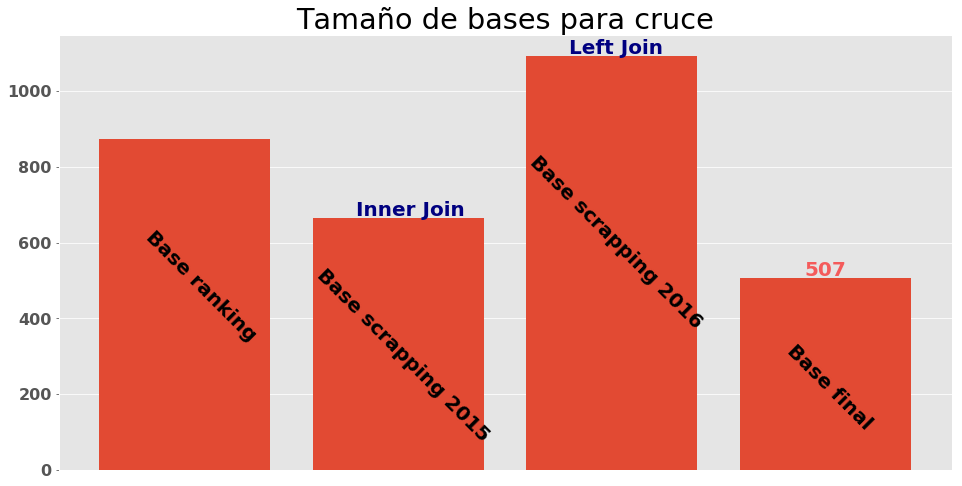

In [1127]:
plt.bar([0,1,2,3],[jugadores_ranking_2015,jugadores_scrapping_2015,jugadores_scrapping_2016,df.shape[0]])
plt.text(-0.2,600,'Base ranking',rotation=315)
plt.text(0.6,500,'Base scrapping 2015',rotation=315)
plt.text(1.6,800,'Base scrapping 2016',rotation=315)
plt.text(2.8,300,'Base final',rotation=315)
plt.text(0.8,670, 'Inner Join',color='navy')
plt.text(1.8,1100, 'Left Join',color='navy')
plt.text(2.9,df.shape[0]+5, df.shape[0],color='r',alpha=0.6)
plt.xticks([])
plt.title('Tamaño de bases para cruce')

Dado que solo tenemos un historico del estado actual (2015), nos quedamos con los jugadores que cruzaron con la base ranking y la del scrapping 2015 y por construccion de datos en transfermarkt nos percatamos que si no tiene valor en 2016 pero si en 2015, el valor actual (2016) es el mismo al valor en el 2015.  Por eso se genera un Left Join para no perder mas datos.

# Tratamiento de Nulos

In [1128]:
# Se continua a generar mas descriptivos ahora del valor.
df.value_2015.isnull().sum(),df.value_2016.isnull().sum()

(0, 105)

In [1129]:
# OJO AQUI RELLENASTE ALGUNOS NULOS!!!! DE LA VARIABLE DEPENDIENTE
df['value_2016'] = np.where(df.value_2016.isnull(),df.value_2015,df.value_2016)
# Esti se hace por que se noto que en los datos de transferencia si no se movio de equipo no guardan el movimiento de la transferencia
# EN ALGUNOS CASOS

In [1131]:
df.shape

(507, 18)

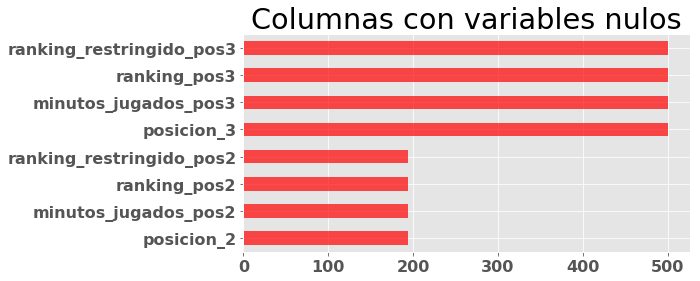

In [1132]:
df.isnull().sum()[df.isnull().sum()!=0].sort_values().plot.barh(color='r',alpha=0.7, 
                                                                title='Columnas con variables nulos'
                                                               ,figsize=(8,4))

## Generacion de variables y descriptivos

In [1133]:
def age_calculator(df):
    
    ref_date = []
    
    for i in range(len(df)):
        birthday = pd.Timestamp('2016-01-15')
        ref_date.append(birthday)
    
    ref_date = pd.to_datetime(ref_date)
    tiempo = ref_date-df['fecha_nacimiento_x']
    edad = tiempo.apply(lambda x: round((x.days)/365,1))
    df['edad'] = edad
    df.drop('fecha_nacimiento_x',1,inplace = True)

In [1134]:
df['edad'] = round((pd.to_datetime('20160115') - df.fecha_nacimiento_x)/ 365 / datetime.timedelta (days=1),0)

In [1135]:
df.edad.describe()

count    507.000000
mean      27.418146
std        4.579848
min       19.000000
25%       24.000000
50%       27.000000
75%       31.000000
max       38.000000
Name: edad, dtype: float64

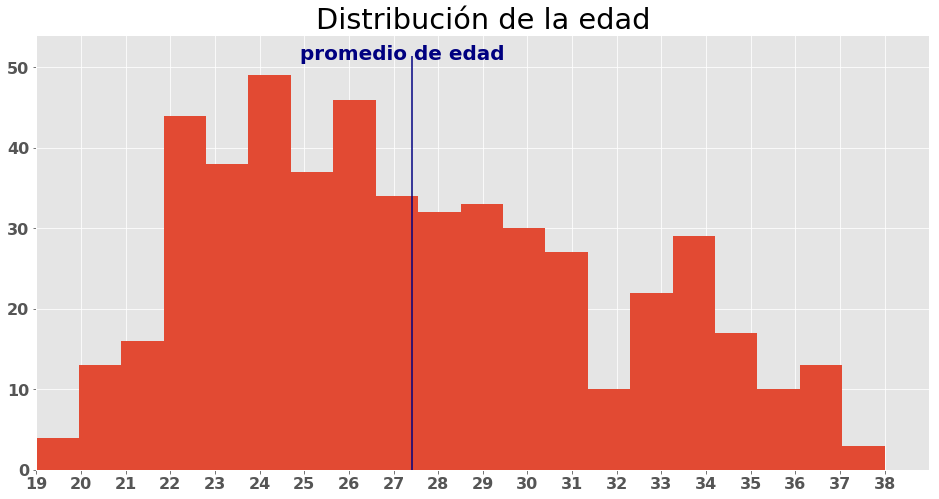

In [1141]:
df.edad.hist(bins=20)
plt.title('Distribución de la edad') 
plt.xlim(19,39)
plt.xticks(range(19,39))
plt.vlines(df.edad.mean(),plt.ylim()[0],plt.ylim()[1], color='navy')
plt.text( 24.9,df.edad.max()+13,'promedio de edad',color='navy');

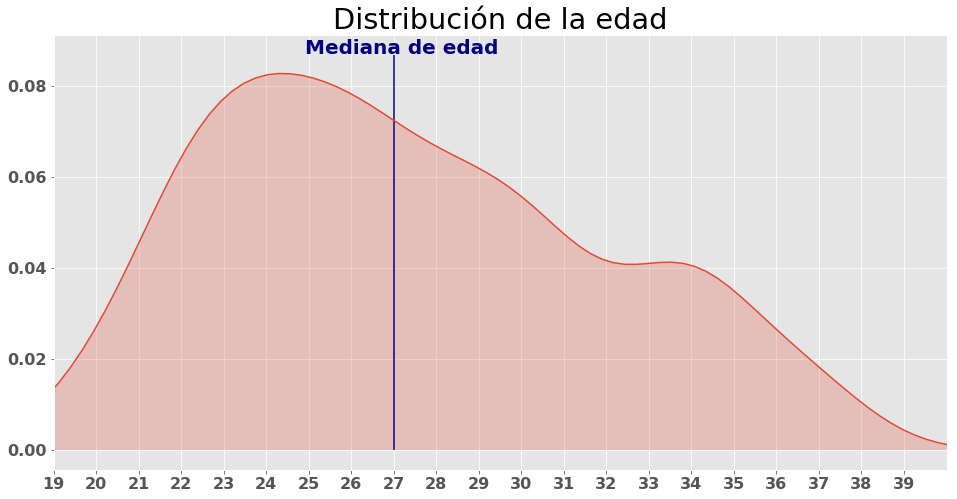

In [1146]:
sns.kdeplot(df.edad,shade=True,legend=False)
plt.title('Distribución de la edad') 
plt.xlim(19,40)
plt.xticks(range(19,40))
plt.vlines(df.edad.median(),plt.ylim()[0],plt.ylim()[1], color='navy')
plt.text( 24.9,0.087,'Mediana de edad',color='navy');

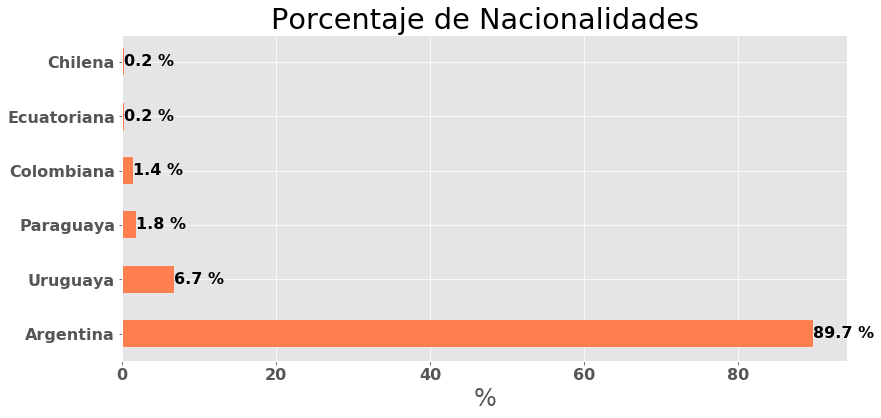

In [1147]:
val_nac = df.nacionalidad.value_counts(normalize=True) * 100
val_nac.plot.barh(
    title='Porcentaje de Nacionalidades',color='coral',figsize=(13,6))
plt.xlabel('%')
for i,j in enumerate(val_nac):
    plt.text(j,i-0.07, '%1.1f %%' % j,fontsize = 16)

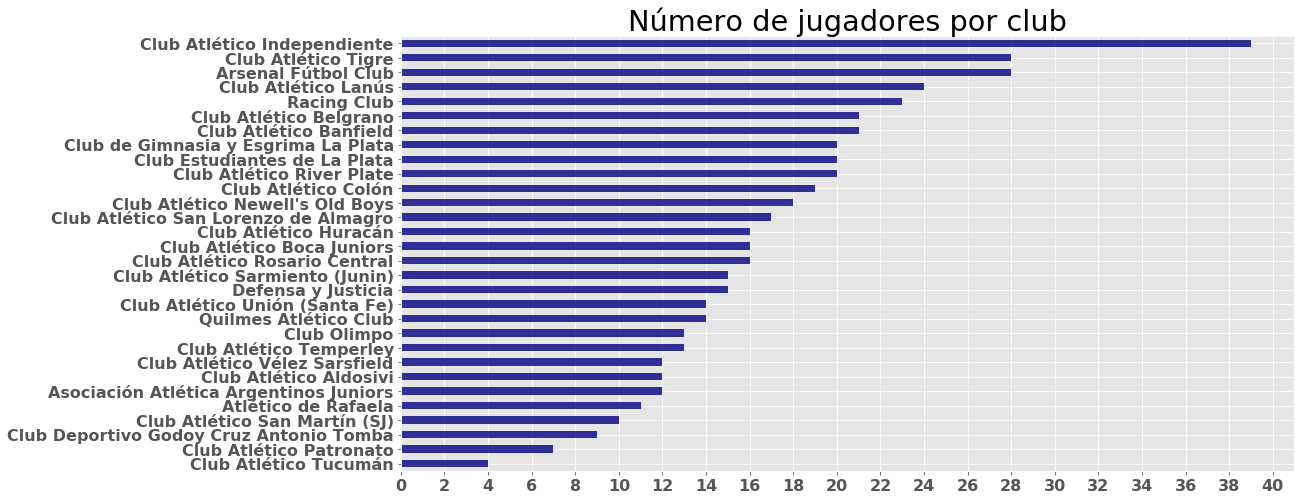

In [1148]:
df.equipo_x.value_counts().sort_values().plot.barh(color='navy',alpha=0.8, title='Número de jugadores por club')
plt.xticks(range(0,42,2));

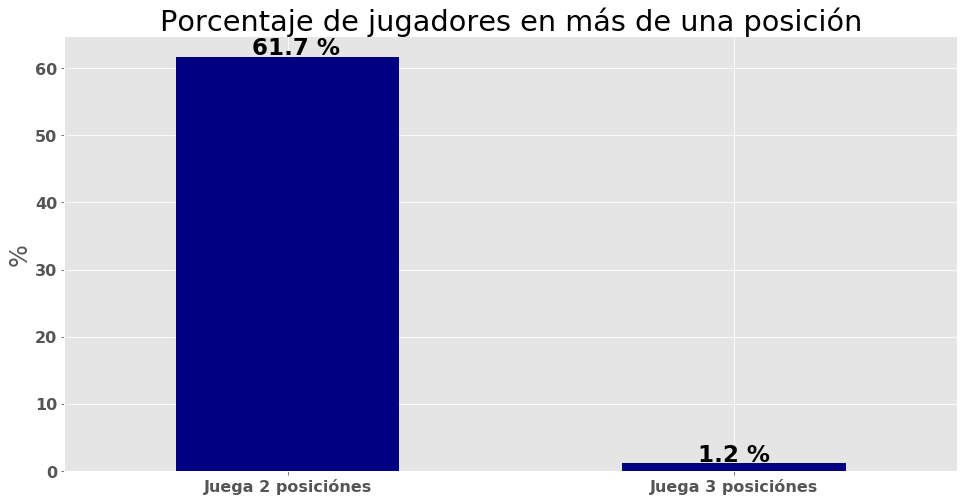

In [1149]:
perc_pos = ((df.shape[0]-df[['posicion_1','posicion_2','posicion_3']].isnull().sum())/df.shape[0]) * 100
perc_pos.drop('posicion_1',inplace=True)
perc_pos.plot.bar(rot=0,color='navy',title='Porcentaje de jugadores en más de una posición')
plt.ylabel('%')
plt.xticks(range(2),['Juega 2 posiciónes','Juega 3 posiciónes'])
for i,j in enumerate(perc_pos):
    plt.text(i-0.08,j+0.3, '%1.1f %%' % j,fontsize = 23)

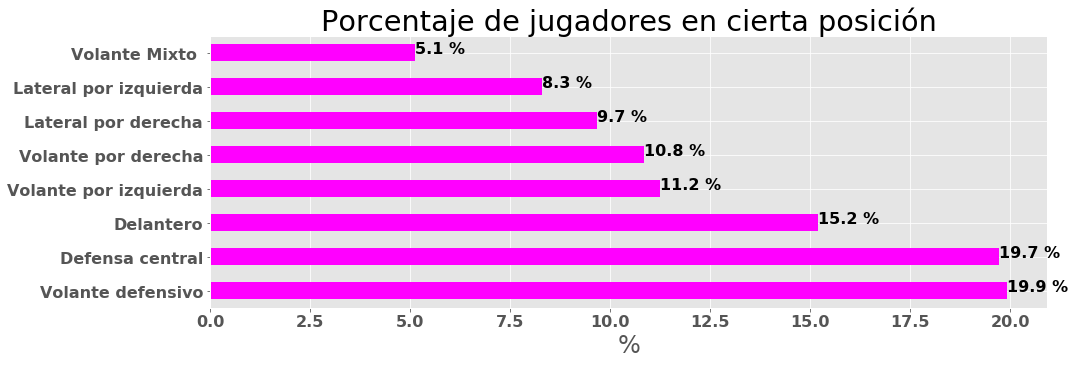

In [1150]:
val_pos = df.posicion_1.value_counts(normalize=True) * 100
val_pos.plot.barh(color='magenta', title='Porcentaje de jugadores en cierta posición', figsize=(15,5))
plt.xlabel('%')
for i,j in enumerate(val_pos):
    plt.text(j,i, '%1.1f %%' % j,fontsize = 16)

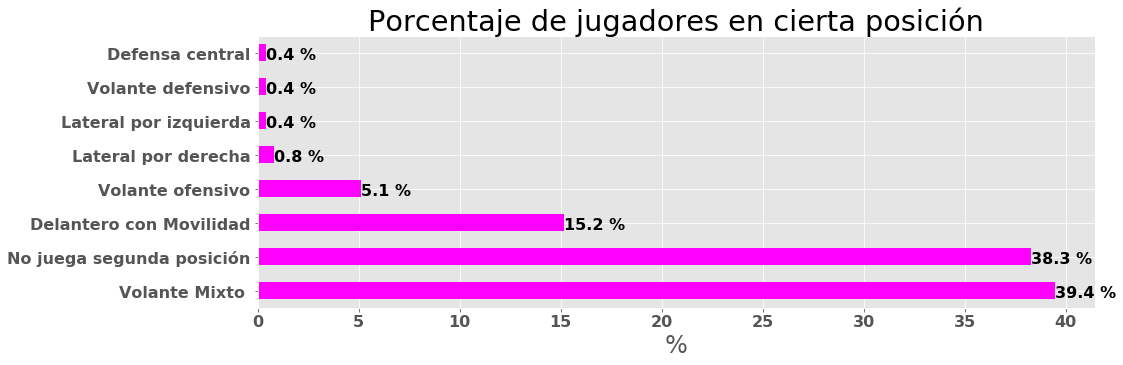

In [1151]:
val_pos = df.posicion_2.value_counts(normalize=True, dropna=False) * 100
val_pos.index = val_pos.index.fillna('No juega segunda posición')
val_pos.plot.barh(color='magenta', title='Porcentaje de jugadores en cierta posición', figsize=(15,5))
plt.xlabel('%')
for i,j in enumerate(val_pos):
    plt.text(j,i-0.2, '%1.1f %%' % j,fontsize = 16)

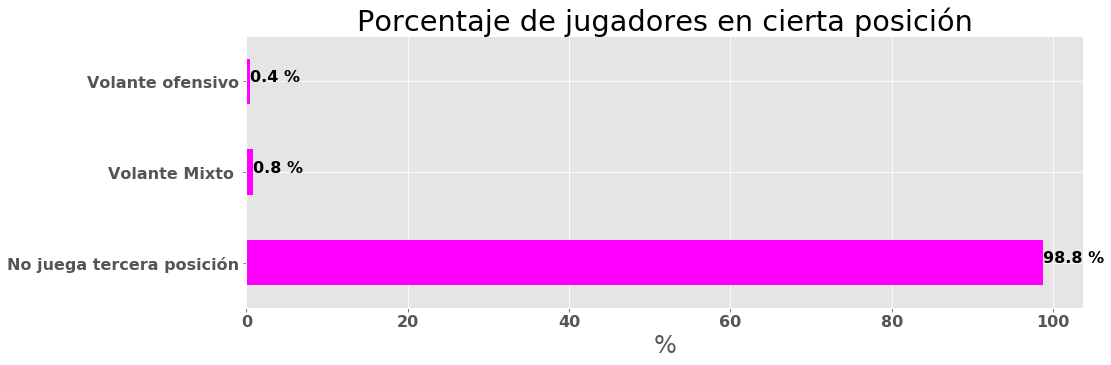

In [1152]:
val_pos = df.posicion_3.value_counts(normalize=True, dropna=False) * 100
val_pos.index = val_pos.index.fillna('No juega tercera posición')
val_pos.plot.barh(color='magenta', title='Porcentaje de jugadores en cierta posición',figsize = (15,5))
plt.xlabel('%')
for i,j in enumerate(val_pos):
    plt.text(j,i, '%1.1f %%' % j,fontsize = 16)

In [1153]:
def total_minutes(df):
    min_pos1 = df['minutos_jugados_pos1']
    min_pos2 = df['minutos_jugados_pos2']
    min_pos3 = df['minutos_jugados_pos3']
    
    df['minutos_totales'] = np.where((min_pos2.isnull()) & (min_pos3.isnull()),min_pos1,
                                np.where((min_pos1 == min_pos2) & (min_pos3.isnull()) , min_pos1,
                                     np.where((min_pos1 == min_pos2) & (min_pos3.notnull()), min_pos1 + min_pos3,
                                              np.where(min_pos2 == min_pos3, min_pos1 + min_pos2, 
                                                       np.where((min_pos1 != min_pos2) & (min_pos2 != min_pos3), 
                                                                min_pos1 + min_pos2 + min_pos3, min_pos1 + min_pos2)))))

In [1154]:
total_minutes(df)

Text(831.0, 40, 'mediana de minutos')

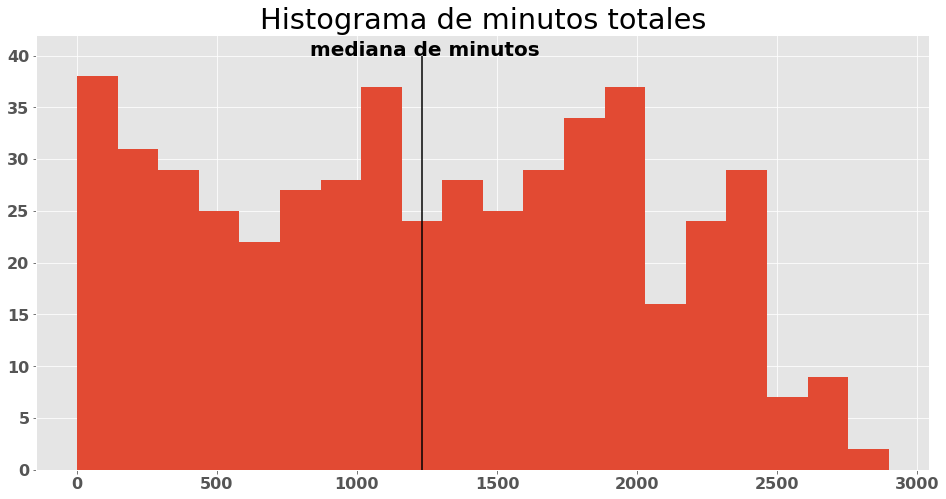

In [1157]:
# Descriptivos de minutos totales
df.minutos_totales.hist(bins=20)
plt.title('Histograma de minutos totales')
mediana = df.minutos_totales.median()
plt.vlines(mediana,0,40)
plt.text(mediana-400,40,'mediana de minutos')

Text(0.5, 1.0, 'Distribución de minutos totales')

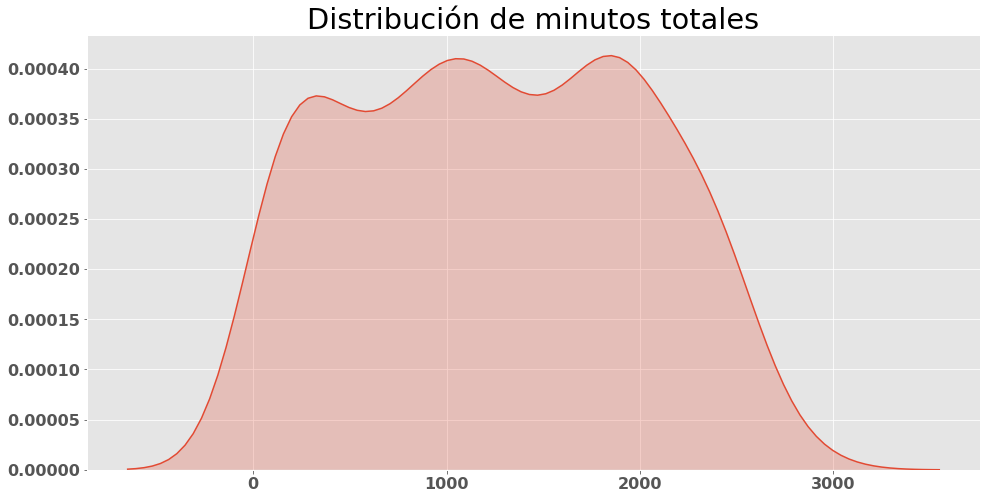

In [1158]:
sns.kdeplot(df.minutos_totales.dropna(),shade=True,legend=False)
plt.title('Distribución de minutos totales')

In [1159]:
def mean_rank(df):
    rank_pos1 = df['ranking_pos1']
    rank_pos2 = df['ranking_pos2']
    rank_pos3 = df['ranking_pos3']
    
    df['ranking_promedio'] = np.where((rank_pos2.isnull()) & (rank_pos3.isnull()), rank_pos1,
                                np.where((rank_pos1 != rank_pos2) & (rank_pos3.isnull()) , (rank_pos1+rank_pos2)/2,
                                     np.where((rank_pos1 == rank_pos2) & (rank_pos3.isnull()), rank_pos1,
                                              np.where(rank_pos2 == rank_pos3, (rank_pos1 + rank_pos2)/2, 
                                                       np.where((rank_pos1 != rank_pos2) & (rank_pos2 != rank_pos3), 
                                                                (rank_pos1 + rank_pos2 + rank_pos3)/3, (rank_pos1 + rank_pos2)/2)))))

In [1160]:
mean_rank(df)

Text(10, 50, 'Jugadores por encima del promedio o outlier')

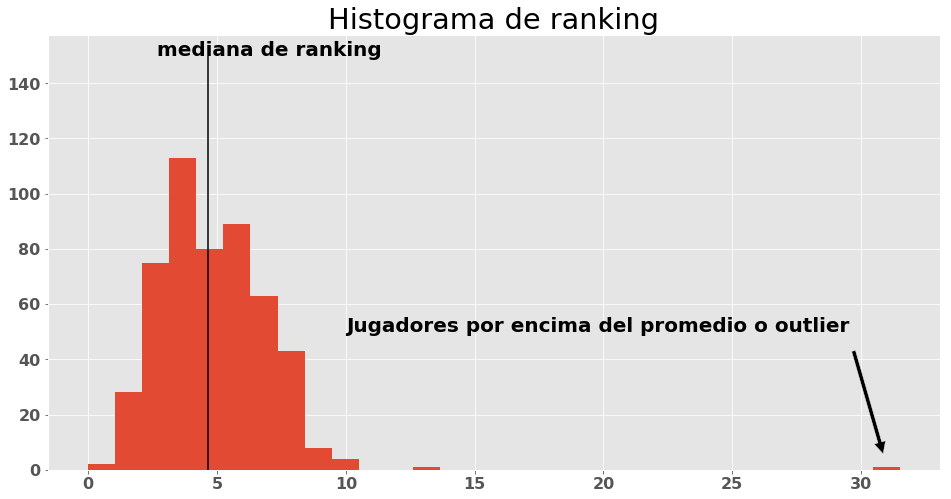

In [1163]:
ax = df.ranking_promedio.hist(bins=30)
plt.title('Histograma de ranking')
mediana = df.ranking_promedio.median()
plt.vlines(mediana,0,150)
plt.text(mediana-2,150,'mediana de ranking')
ax.annotate('Jugadores por encima del promedio o outlier', xy=(31, 1), xytext=(10, 50),
            arrowprops=dict(facecolor='black', shrink=0.1),)

In [1167]:
df[df.ranking_promedio > df.ranking_promedio.quantile(0.99)]

,jugador,fecha_nacimiento_x,nacionalidad,equipo_x,posicion_1,posicion_2,posicion_3,minutos_jugados_pos1,minutos_jugados_pos2,minutos_jugados_pos3,...,ranking_pos2,ranking_pos3,ranking_restringido_pos1,ranking_restringido_pos2,ranking_restringido_pos3,value_2015,value_2016,edad,minutos_totales,ranking_promedio
128,"Cavallaro, Juan",1994-06-28,Argentina,Club Estudiantes de La Plata,Volante por izquierda,Volante Mixto,NaN,8.0,8.0,NaN,...,14.850000,NaN,0.000000,0.000000,NaN,0.80,1.00,22.0,8.0,12.670312
211,"Figueroa, Leandro",1993-03-28,Argentina,Club Atlético Newell's Old Boys,Volante Mixto,Volante ofensivo,NaN,1.0,1.0,NaN,...,13.500000,NaN,0.000000,0.000000,NaN,0.25,0.25,23.0,1.0,31.500000
224,"Funes Mori, Ramiro",1991-03-05,Argentina,Club Atlético River Plate,Defensa central,NaN,NaN,990.0,NaN,NaN,...,NaN,NaN,9.509182,NaN,NaN,4.00,4.00,25.0,990.0,9.509182
303,"Mammana, Emanuel",1996-02-10,Argentina,Club Atlético River Plate,Defensa central,NaN,NaN,1211.0,NaN,NaN,...,NaN,NaN,9.866259,NaN,NaN,0.25,0.25,20.0,1211.0,9.866259
419,"Ponzio, Leonardo",1982-01-29,Argentina,Club Atlético River Plate,Volante defensivo,Volante Mixto,NaN,1211.0,1211.0,NaN,...,9.390173,NaN,10.893270,9.390173,NaN,1.20,0.80,34.0,1211.0,10.141722
456,"Rodriguez, Guido",1994-04-12,Argentina,Defensa y Justicia,Volante defensivo,Volante Mixto,NaN,664.0,664.0,NaN,...,9.600452,NaN,11.172063,9.600452,NaN,0.30,0.30,22.0,664.0,10.386258


Existen jugadores que juegan poco y el ranking es muy alto por lo que la idea de un ranking restringido tiene sentido

In [1169]:
def mean_rank_restringido(df):
    rank_pos1 = df['ranking_restringido_pos1']
    rank_pos2 = df['ranking_restringido_pos2']
    rank_pos3 = df['ranking_restringido_pos3']
    
    df['ranking_restringido_promedio'] = np.where((rank_pos2.isnull()) & (rank_pos3.isnull()), rank_pos1,
                                np.where((rank_pos1 != rank_pos2) & (rank_pos3.isnull()) , (rank_pos1+rank_pos2)/2,
                                     np.where((rank_pos1 == rank_pos2) & (rank_pos3.isnull()), rank_pos1,
                                              np.where(rank_pos2 == rank_pos3, (rank_pos1 + rank_pos2)/2, 
                                                       np.where((rank_pos1 != rank_pos2) & (rank_pos2 != rank_pos3), 
                                                                (rank_pos1 + rank_pos2 + rank_pos3)/3, (rank_pos1 + rank_pos2)/2)))))

In [1170]:
mean_rank_restringido(df)

Text(1.8427096774193599, 125, 'mediana de ranking restringido')

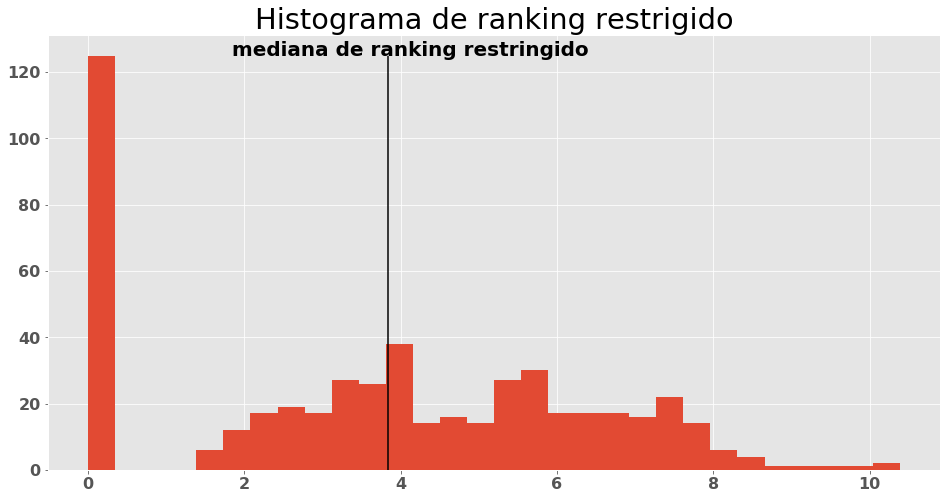

In [1172]:
ax = df.ranking_restringido_promedio.hist(bins=30)
plt.title('Histograma de ranking restrigido')
mediana = df.ranking_restringido_promedio.median()
plt.vlines(mediana,0,125)
plt.text(mediana-2,125,'mediana de ranking restringido')


Text(10, 50, 'Jugadores por encima del promedio')

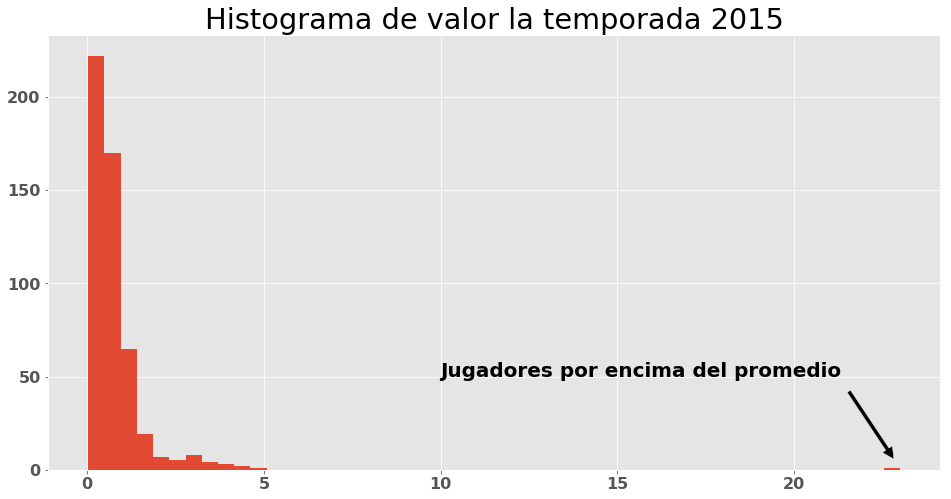

In [1173]:
ax = df.value_2015.hist(bins=50)
plt.title('Histograma de valor la temporada 2015')
ax.annotate('Jugadores por encima del promedio', xy=(23, 1), xytext=(10, 50),
            arrowprops=dict(facecolor='black', shrink=0.1),)

*Posible tratamiento de outliers*

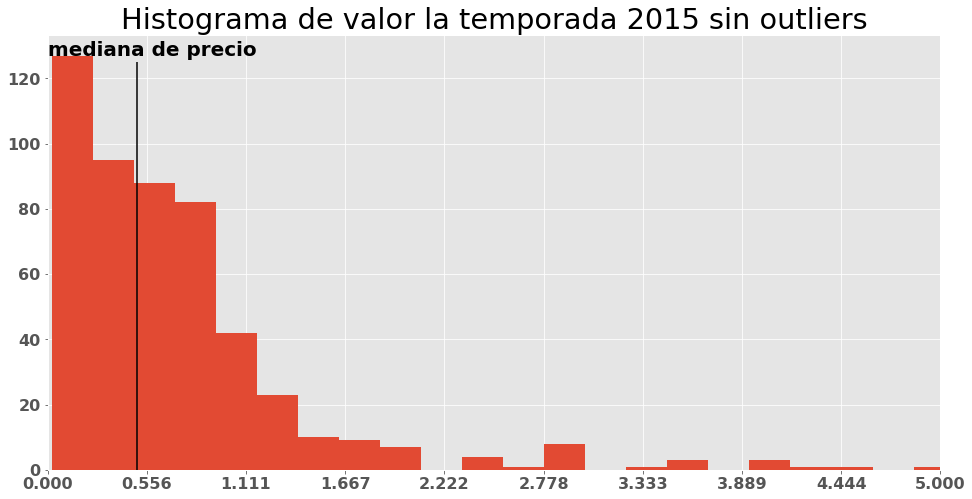

In [1182]:
df.value_2015.hist(bins=100)
plt.title('Histograma de valor la temporada 2015 sin outliers')
plt.xlim(0,5)
mediana = df[df.value_2015 < df.value_2015.quantile(0.9)].value_2015.median()
plt.vlines(mediana,0,125)
plt.text(mediana-0.5,127,'mediana de precio')
plt.xticks(np.linspace(0,5,10));

# Variable Dependiente

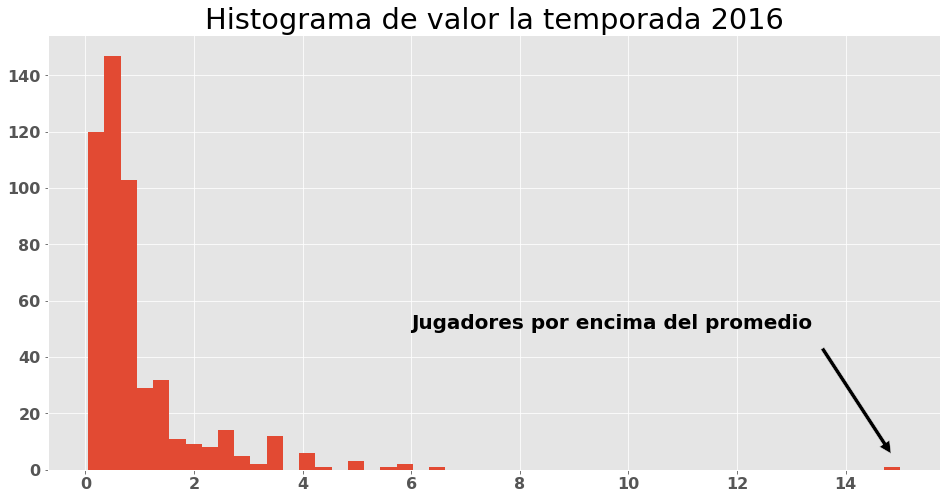

In [1183]:
ax = df.value_2016.hist(bins=50)
plt.title('Histograma de valor la temporada 2016')
ax.annotate('Jugadores por encima del promedio', xy=(15, 1), xytext=(6, 50),
            arrowprops=dict(facecolor='black', shrink=0.1),);

Posible tratamiento de outliers

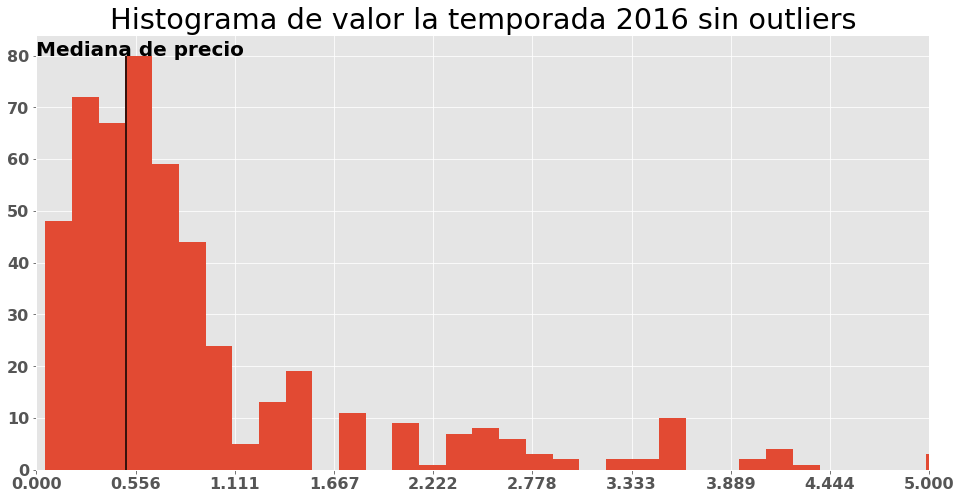

In [1187]:
df.value_2016.hist(bins=100)
plt.title('Histograma de valor la temporada 2016 sin outliers')
plt.xlim(0,5)
mediana = df[df.value_2016 < df.value_2016.quantile(0.9)].value_2016.median()
plt.vlines(mediana,0,80)
plt.text(mediana-0.5,80,'Mediana de precio')
plt.xticks(np.linspace(0,5,10));

# Mas Variables y relleno

In [1189]:
# Se rellena el valor de 2015 con el 0.05 que corresponde a la mayoria que esta ahi
# df.value_2015.fillna(df.value_2015.quantile(0.05),inplace=True)
# YANO ES NECESARIO POR QUE NO HAY NULOS AQUI

# se rellena despues de los descriptivos
df.posicion_2.fillna('No aplica', inplace=True)
df.posicion_3.fillna('No aplica', inplace=True)

df.ranking_pos2.fillna(0, inplace=True)
df.ranking_pos3.fillna(0, inplace=True)

df.ranking_restringido_pos2.fillna(0, inplace=True)
df.ranking_restringido_pos3.fillna(0, inplace=True)

df.minutos_jugados_pos2.fillna(0, inplace=True)
df.minutos_jugados_pos3.fillna(0, inplace=True)

Text(0.5, 1.0, 'Balance de la temporada 2016 al 2015')

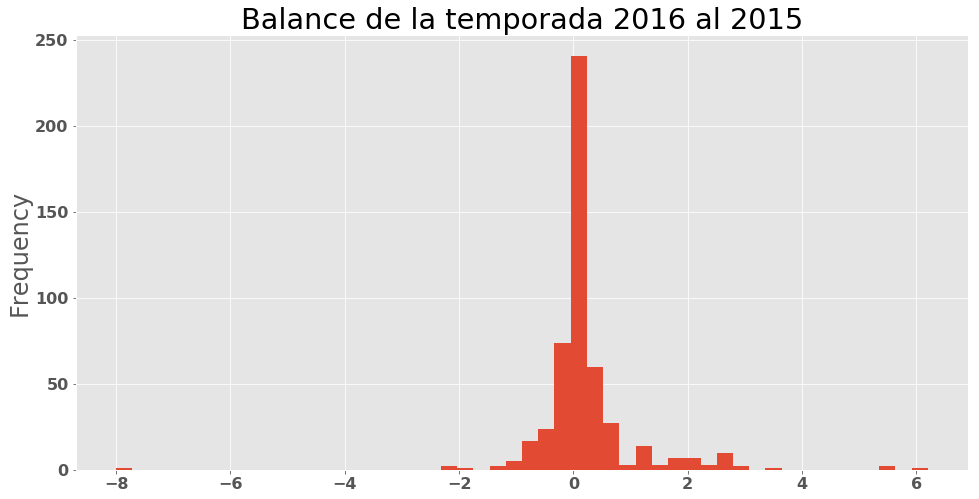

In [1194]:
(df.value_2016 - df.value_2015).plot.hist(bins = 50)
plt.title('Balance de la temporada 2016 al 2015')

Nos indica que la mayoria de los jugadores se mantuvo en el mismo precio de una temporada a otra
+ tener en cuenta la construccion de datos
+ tratamiento de nulos value_2015, value_2016

Y existe otra minoria que _crecio_ ligeramente

In [1195]:
# Tratamiento de nulos equipo_x
quantile25_equipo = df.equipo_x.value_counts().quantile(0.25)
equipos_a_elegir = df.equipo_x.value_counts()[df.equipo_x.value_counts()<quantile25_equipo].index.values
equipos_a_elegir

array(['Club Atlético Vélez Sarsfield', 'Club Atlético Aldosivi',
       'Asociación Atlética Argentinos Juniors', 'Atlético de Rafaela',
       'Club Atlético San Martín (SJ)',
       'Club Deportivo Godoy Cruz Antonio Tomba',
       'Club Atlético Patronato', 'Club Atlético Tucumán'], dtype=object)

In [1196]:
for i,j in zip(df.equipo_x,df.index):
    if type(i) == float:
        value = np.random.choice(equipos_a_elegir)
#         print(i,j)
        df.set_value(j, 'equipo_x', value)

In [1197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 581
Data columns (total 22 columns):
jugador                         507 non-null object
fecha_nacimiento_x              507 non-null datetime64[ns]
nacionalidad                    507 non-null object
equipo_x                        507 non-null object
posicion_1                      507 non-null object
posicion_2                      507 non-null object
posicion_3                      507 non-null object
minutos_jugados_pos1            507 non-null float64
minutos_jugados_pos2            507 non-null float64
minutos_jugados_pos3            507 non-null float64
ranking_pos1                    507 non-null float64
ranking_pos2                    507 non-null float64
ranking_pos3                    507 non-null float64
ranking_restringido_pos1        507 non-null float64
ranking_restringido_pos2        507 non-null float64
ranking_restringido_pos3        507 non-null float64
value_2015                      507 non-null f

In [1198]:
df.minutos_totales.fillna(df.minutos_totales.median(), inplace=True)

In [1199]:
corr_df = df.corr().value_2016

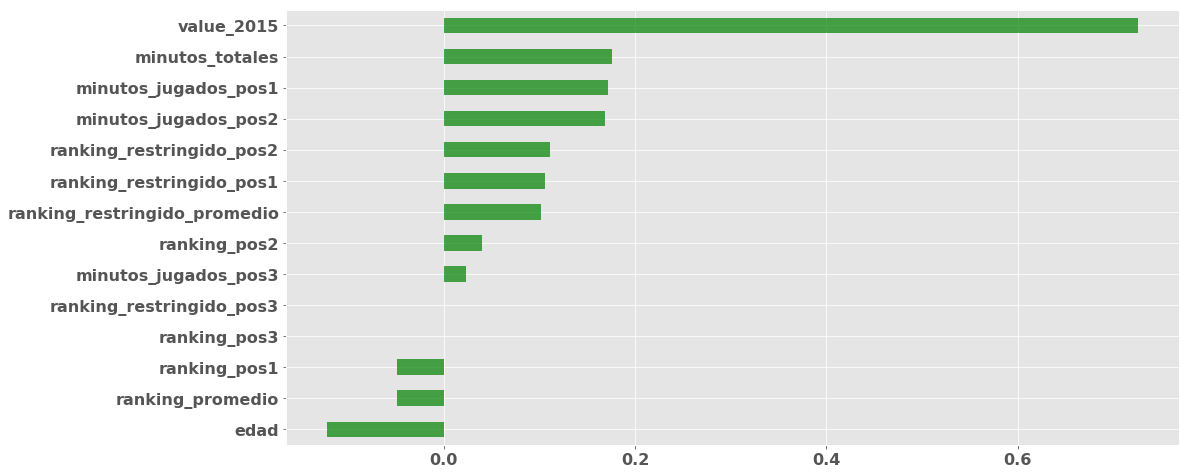

In [1201]:
corr_df.sort_values().drop('value_2016').plot.barh(color='g',alpha=0.7)

Observamos una correlacion positiva con el valor de la temporada anterior, que es como lo esperabamos, y una correlacion negativa con respecto la edad que nos hace sentido...

Sin embargo hay que checar por que los datos nos dan una correlacion diferente con respecto al ranking 1 y 3 esperando que a mayor ranking mayor valor de la siguiente temporada.
+ Posible por el tratamiento de nulos

Por otro lado los ranking restringidos si hacen sentido al tener la correlacion positiva.

Text(0.5, 0, 'Millones de Euros')

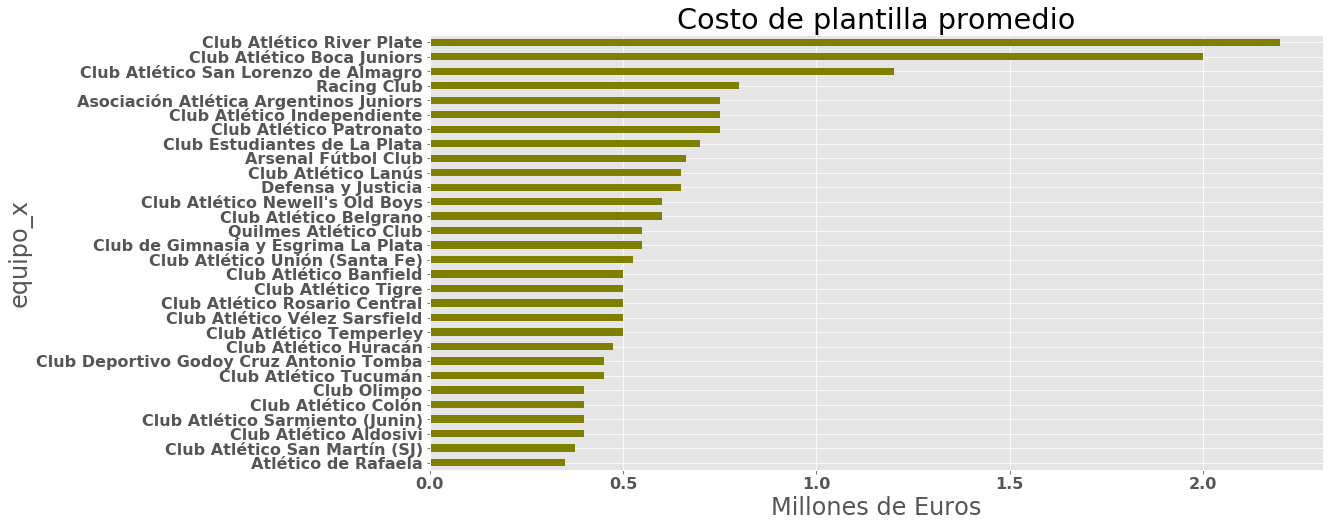

In [1202]:
df.groupby('equipo_x').value_2016.median().sort_values(ascending=True).plot.barh(color = 'olive', 
                                                                               title='Costo de plantilla promedio')
plt.xlabel('Millones de Euros')

Text(0, 0.5, 'Millones de Euros')

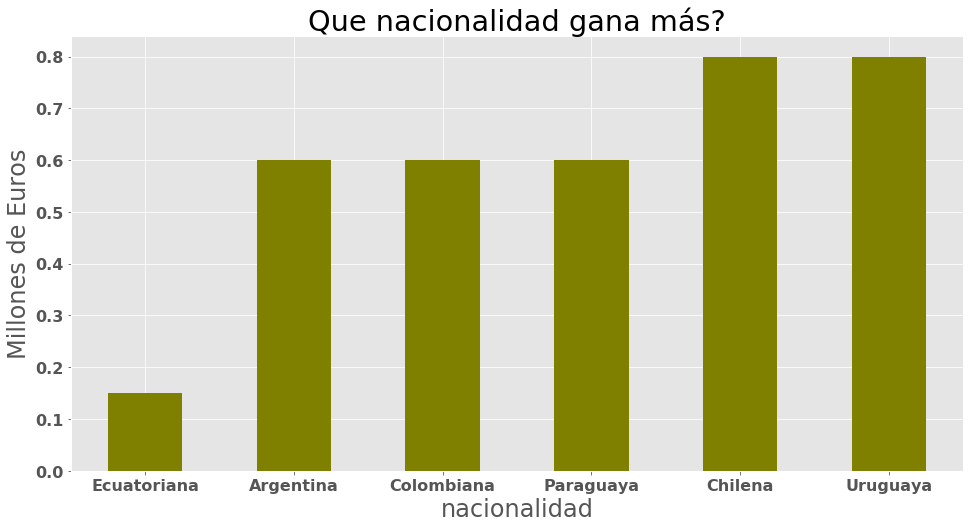

In [1203]:
df.groupby('nacionalidad').value_2016.median().sort_values().plot.bar(rot=0,
                                                                      color='olive',
                                                                     title='Que nacionalidad gana más?')
plt.ylabel('Millones de Euros')

Text(0.5, 0, 'Millones de Euros')

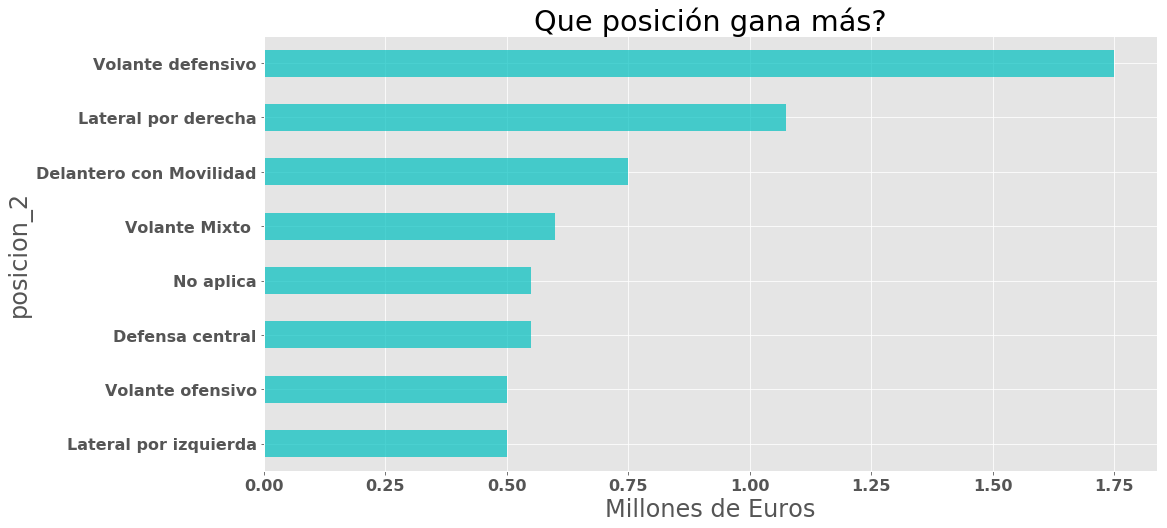

In [1205]:
df.groupby('posicion_2').value_2016.median().sort_values().plot.barh(color='c', alpha=0.7,title='Que posición gana más?')
plt.xlabel('Millones de Euros')

Text(0.5, 0, 'Millones de Euros')

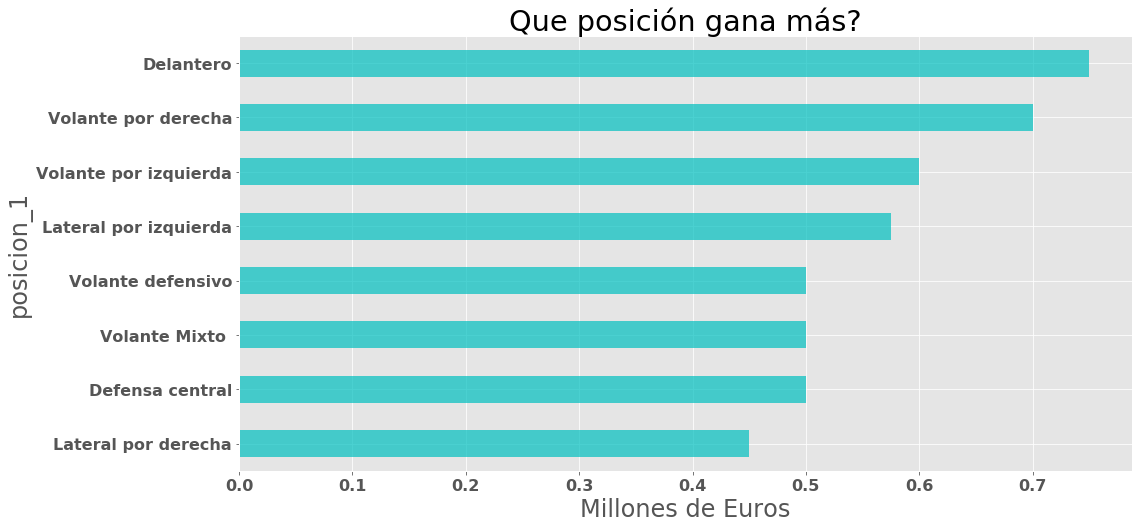

In [1204]:
df.groupby('posicion_1').value_2016.median().sort_values().plot.barh(color='c', alpha=0.7,title='Que posición gana más?')
plt.xlabel('Millones de Euros')

Text(0.5, 0, 'Millones de Euros')

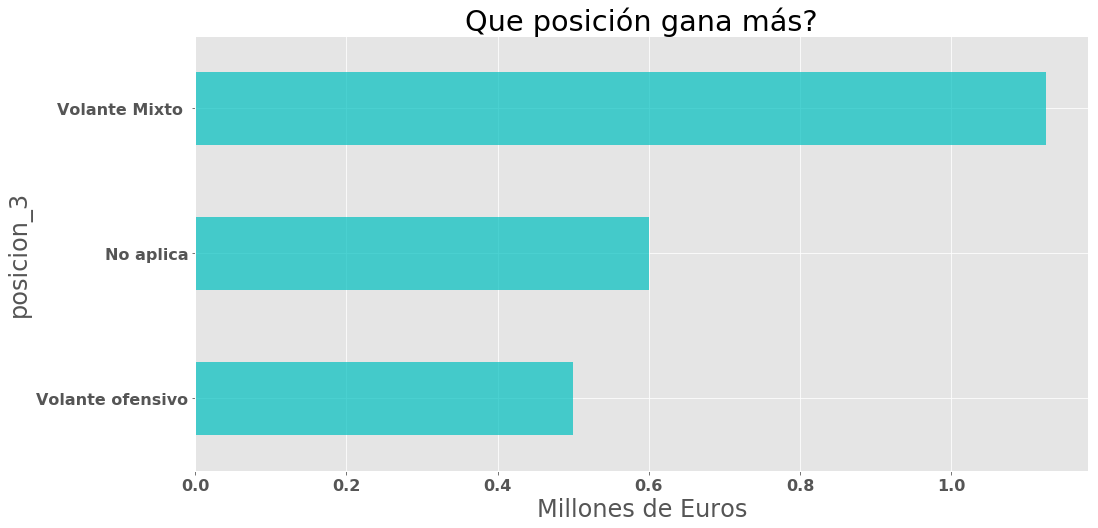

In [1206]:
df.groupby('posicion_3').value_2016.median().sort_values().plot.barh(color='c', alpha=0.7,title='Que posición gana más?')
plt.xlabel('Millones de Euros')

Text(0, 0.5, 'Millones de Euros')

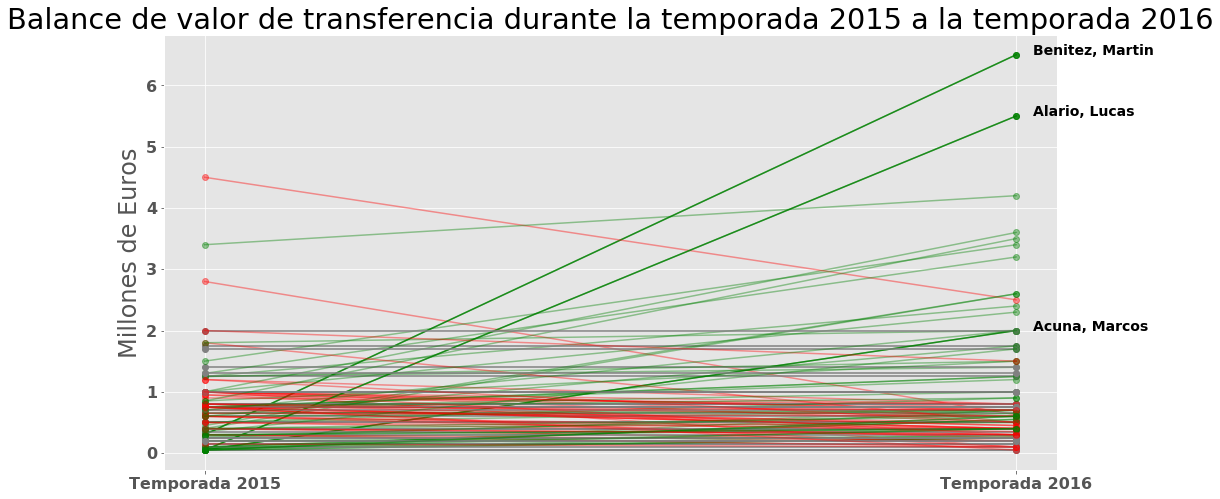

In [1221]:
for i,j,z in df[['value_2015','value_2016','jugador']].sample(120).values:
    if j-i == 0: #x        y
        plt.plot( (0,1),(i,j),'-', marker='o', color = 'grey')
    elif j-i > 0: #x        y
        plt.plot( (0,1),(i,j),'-', marker='o', color = 'g', alpha=0.4)
    else:
        plt.plot( (0,1),(i,j),'-', marker='o', color = 'r', alpha=0.4)
    
    if j/i > 20:
        plt.text(1.02,j,z, fontsize = 14)
        plt.plot( (0,1),(i,j),'-', marker='o', color = 'g', alpha=0.8)
        
plt.title('Balance de valor de transferencia durante la temporada 2015 a la temporada 2016')
plt.xticks(range(2),['Temporada 2015','Temporada 2016'])
plt.ylabel('Millones de Euros')

Si subieron 20 veces su valor! mostramos el nombre del jugador. Nos interesa saber como son esos jugadores y como eran sus stats que los hicieron subir tanto.

In [1212]:
df['cociente'] = df.value_2016 / df.value_2015

40.0 Acuna, Marcos
110.0 Alario, Lucas
50.0 Conti, German


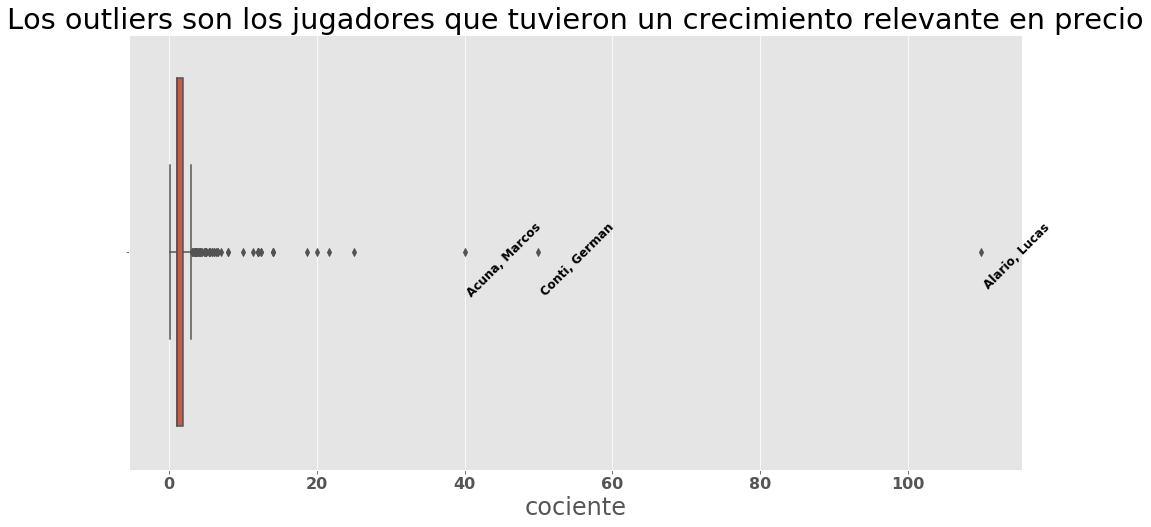

In [1217]:
sns.boxplot(df.cociente)
plt.title('Los outliers son los jugadores que tuvieron un crecimiento relevante en precio')
for i,j in df[df.cociente > 39][['cociente','jugador']].values:
    print(i,j)
    plt.text(i,-0.05,j, fontsize = 12,rotation=45);

In [1224]:
jugadores_pro = ['Acuna, Marcos','Alario, Lucas','Conti, German']
df[df.jugador.isin(jugadores_pro)][['jugador','nacionalidad', 'equipo_x','value_2015',
       'value_2016','minutos_totales', 'ranking_promedio',
       'ranking_restringido_promedio', 'cociente']]

,jugador,nacionalidad,equipo_x,value_2015,value_2016,minutos_totales,ranking_promedio,ranking_restringido_promedio,cociente
4,"Acuna, Marcos",Argentina,Racing Club,0.05,2.0,1557.0,5.143353,5.143353,40.0
14,"Alario, Lucas",Argentina,Club Atlético River Plate,0.05,5.5,1286.0,2.240727,2.240727,110.0
144,"Conti, German",Argentina,Club Atlético Colón,0.05,2.5,2513.0,7.650143,7.650143,50.0


In [1225]:
df[df.jugador.isin(jugadores_pro)].median()

minutos_jugados_pos1            1557.000000
minutos_jugados_pos2            1286.000000
minutos_jugados_pos3               0.000000
ranking_pos1                       4.772254
ranking_pos2                       1.715319
ranking_pos3                       0.000000
ranking_restringido_pos1           4.772254
ranking_restringido_pos2           1.715319
ranking_restringido_pos3           0.000000
value_2015                         0.050000
value_2016                         2.500000
edad                              23.000000
minutos_totales                 1557.000000
ranking_promedio                   5.143353
ranking_restringido_promedio       5.143353
cociente                          50.000000
dtype: float64

In [1226]:
cols_numeric = ['minutos_jugados_pos1','minutos_jugados_pos2','minutos_jugados_pos3','ranking_pos1','ranking_pos2','ranking_pos3','ranking_restringido_pos1','ranking_restringido_pos2','ranking_restringido_pos3','value_2015','value_2016','edad','minutos_totales','ranking_promedio',
 'ranking_restringido_promedio','cociente']

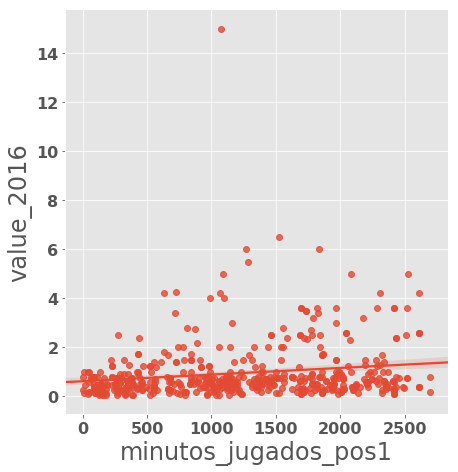

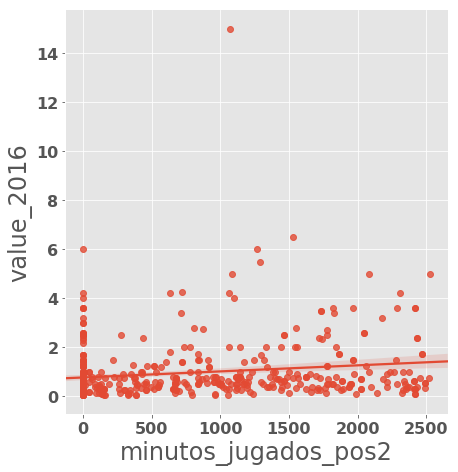

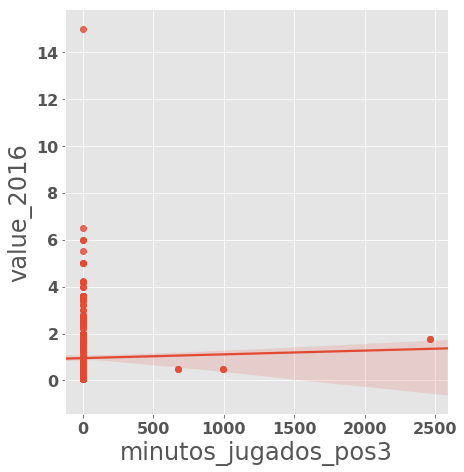

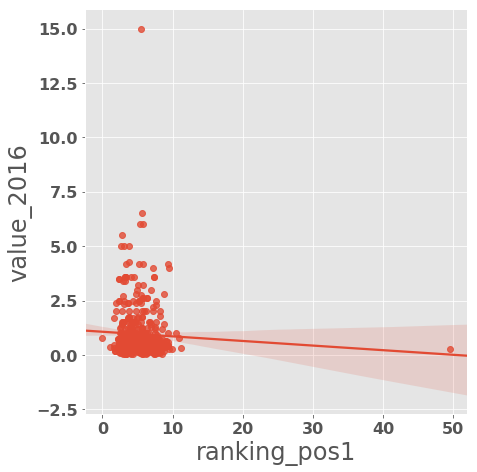

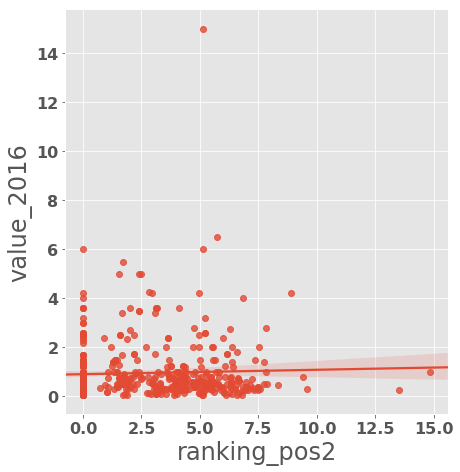

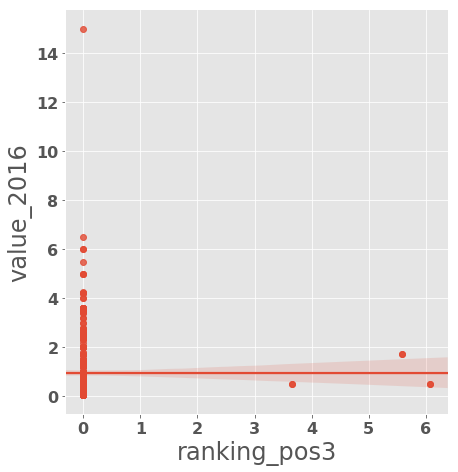

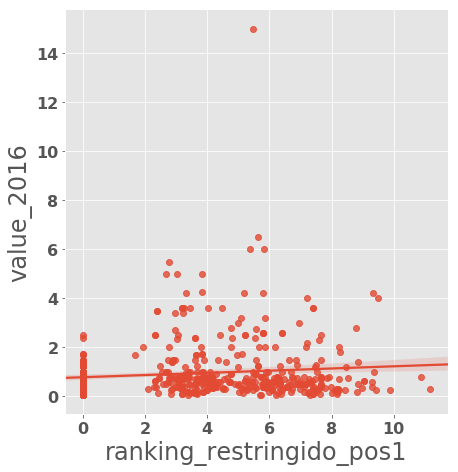

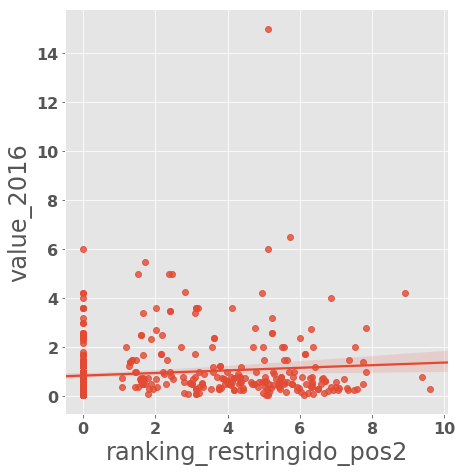

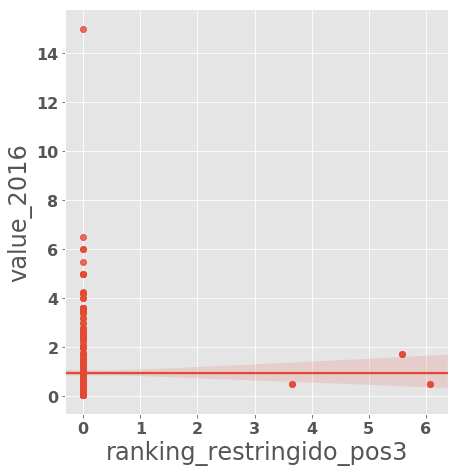

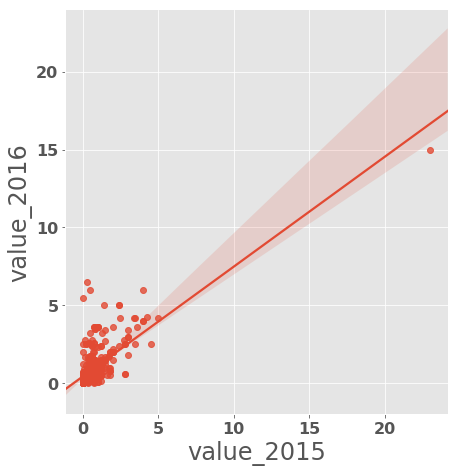

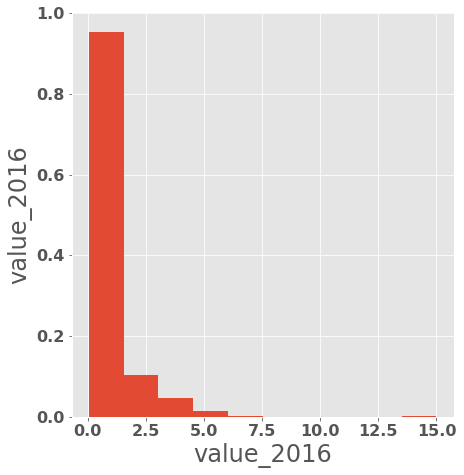

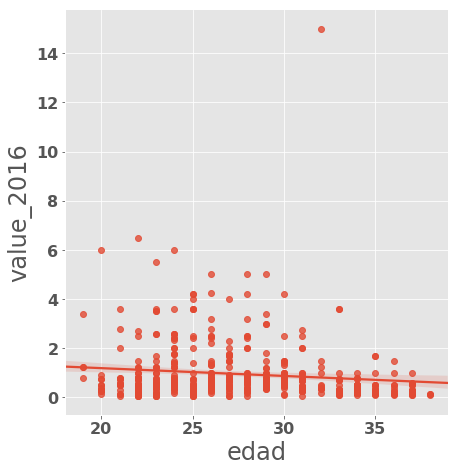

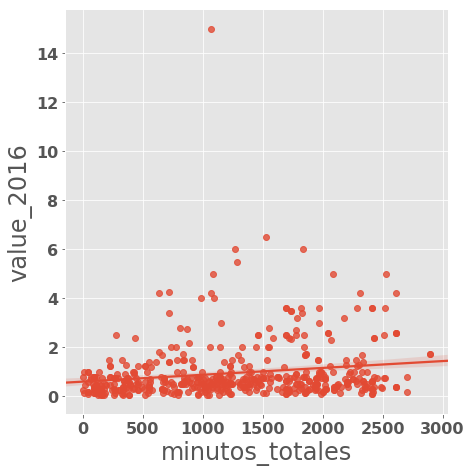

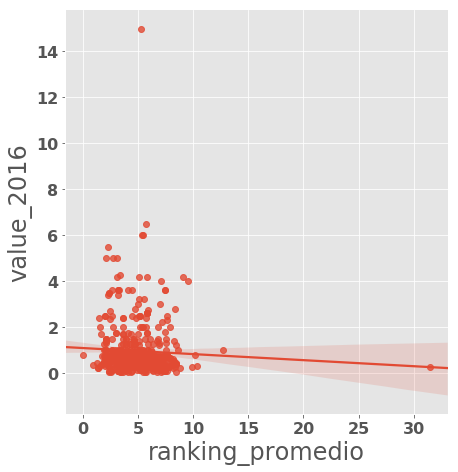

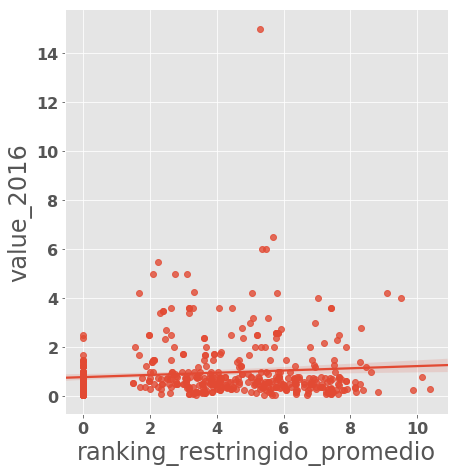

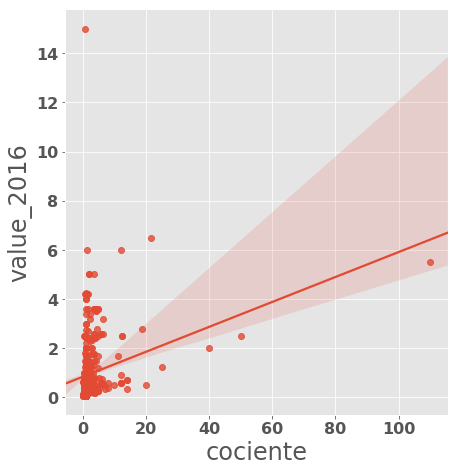

In [1228]:
for i in cols_numeric:
    sns.pairplot(df, x_vars=i, y_vars='value_2016', height=7, aspect=1, kind='reg')

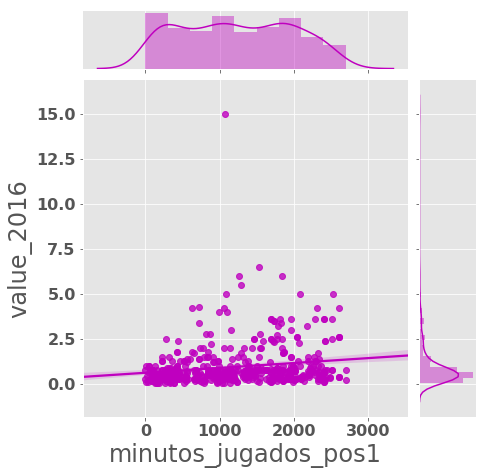

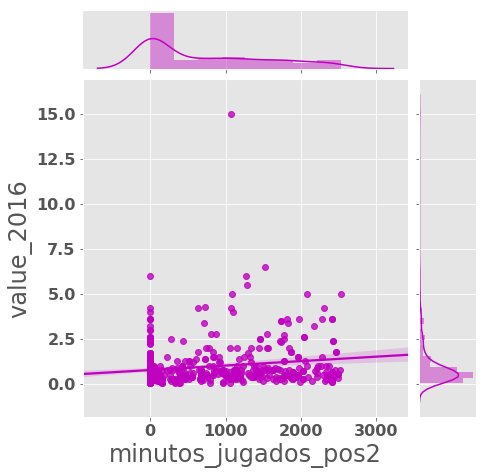

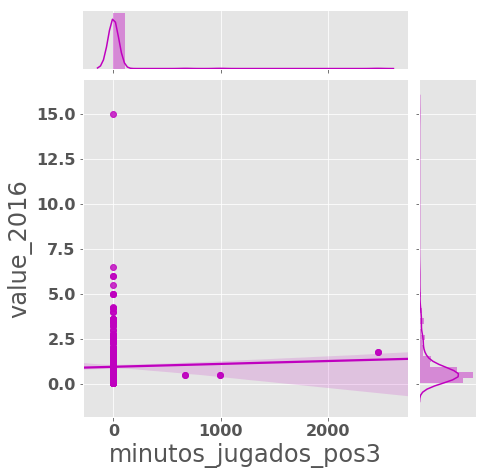

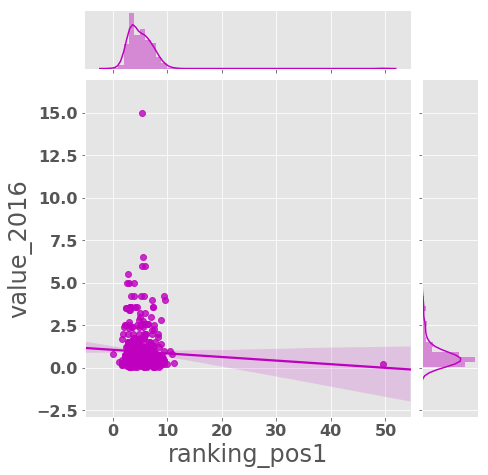

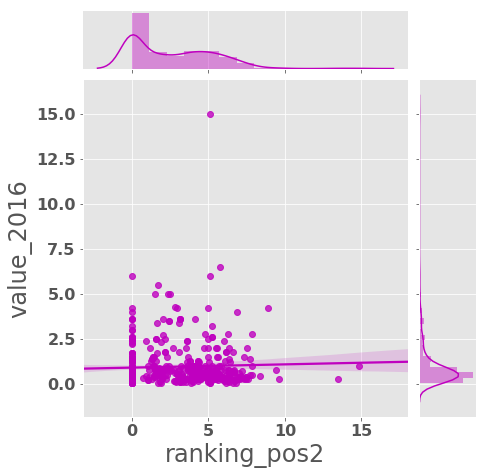

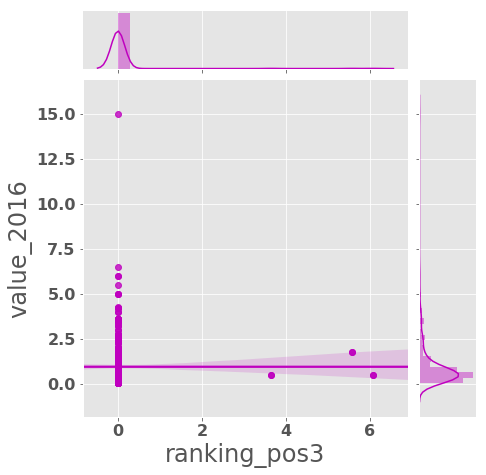

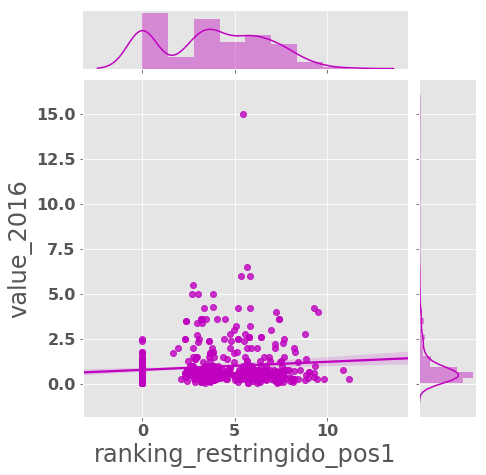

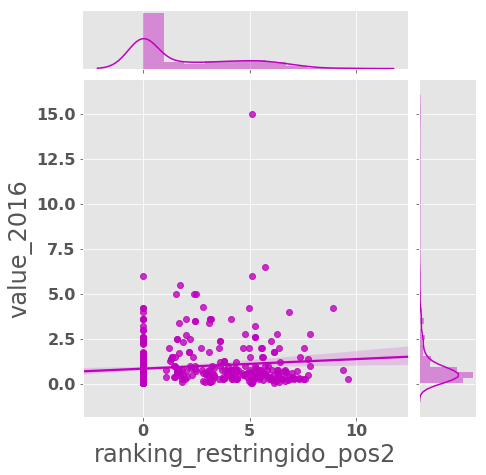

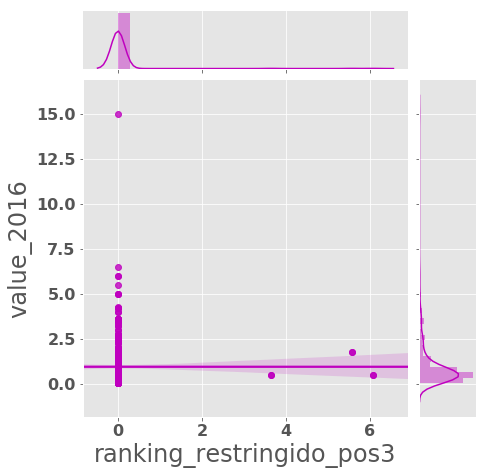

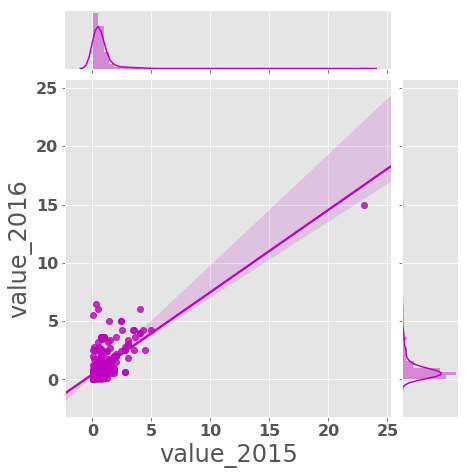

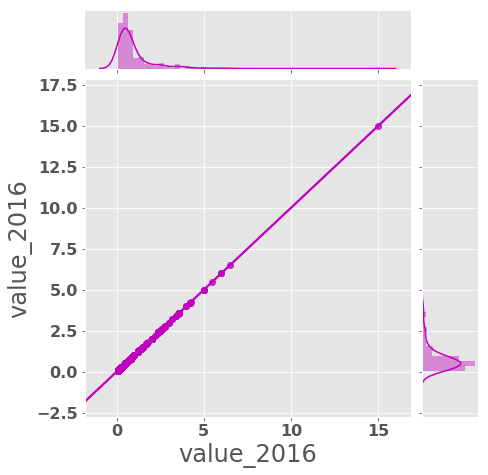

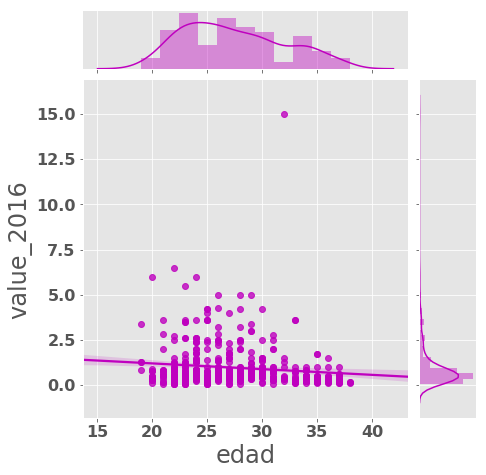

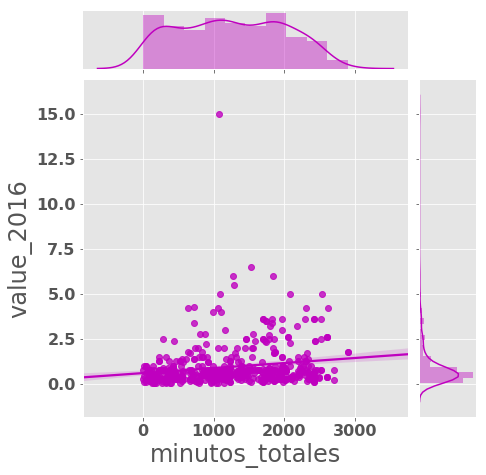

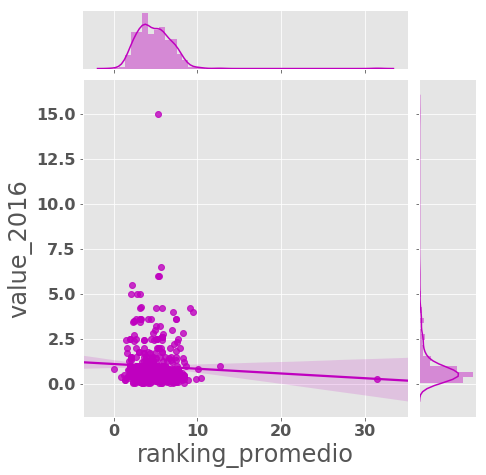

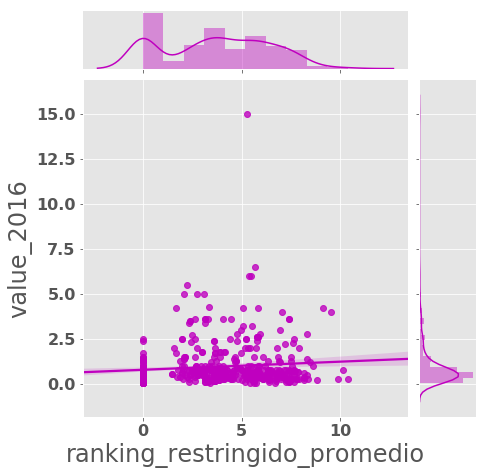

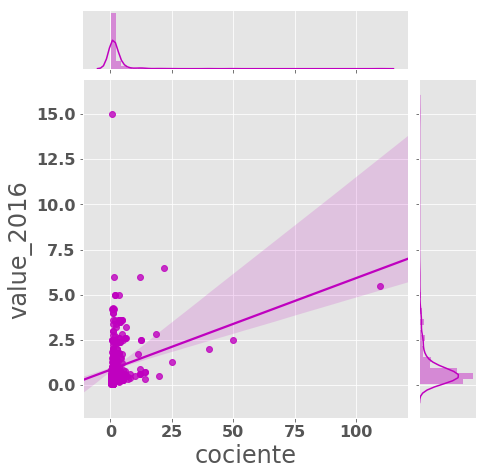

In [1232]:
for i in cols_numeric:
    g = sns.jointplot(i, "value_2016", data=df, kind="reg",
#                   xlim=(0, 60), ylim=(0, 12), 
                      color="m", height=7)

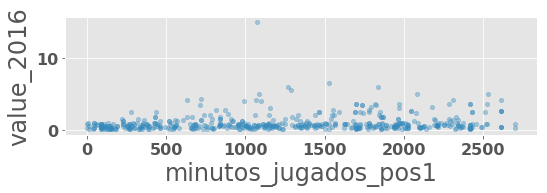

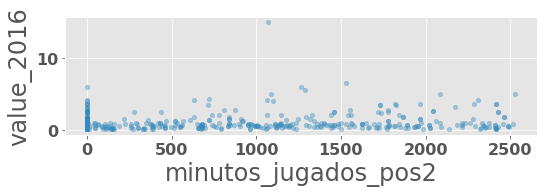

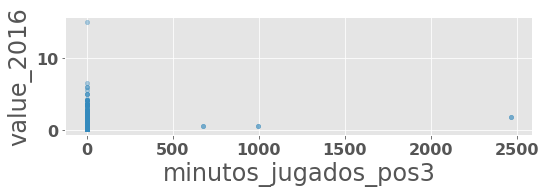

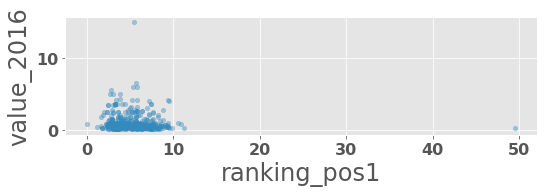

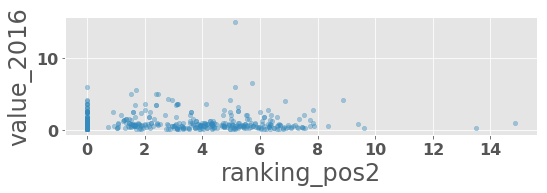

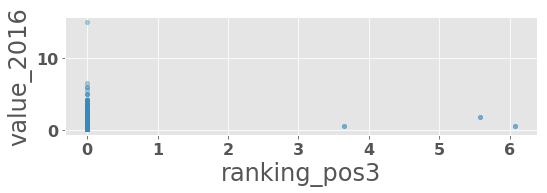

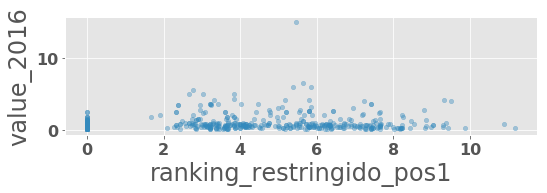

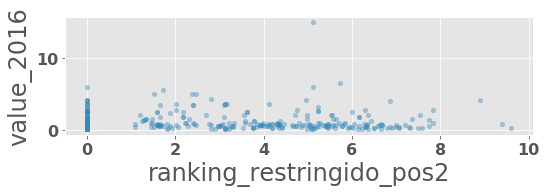

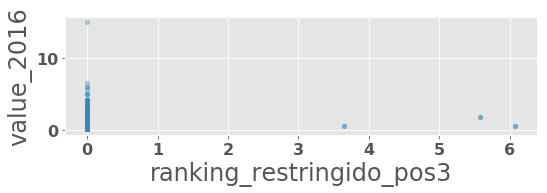

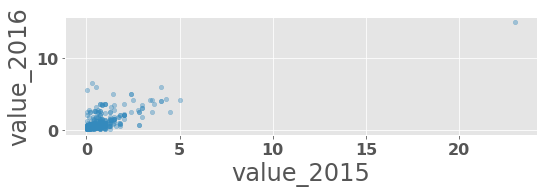

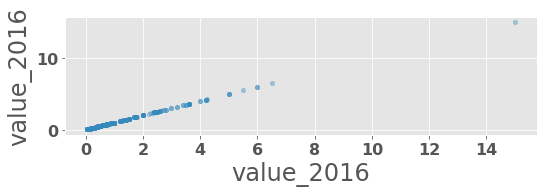

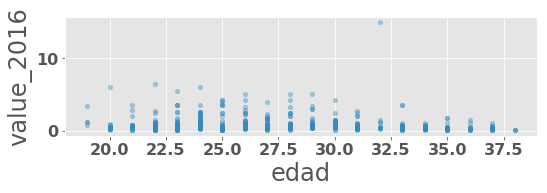

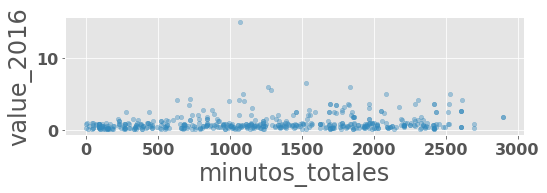

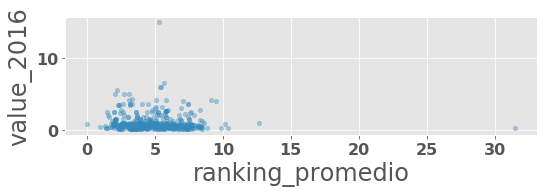

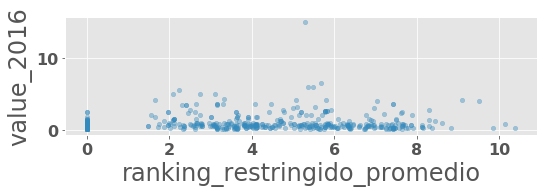

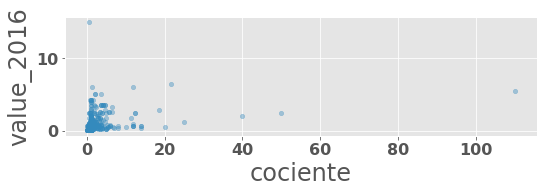

In [1233]:
for i in cols_numeric:
    df.plot.scatter(x=i,y='value_2016',figsize=(8,3),alpha=0.4)
    plt.tight_layout()

In [1236]:
# ya limpio el DF se procede a generar los modelos
df.to_pickle('df_4_regresion_clean.pkl')